# Explorative Data and Model Analysis

## Installing and importing packages

In [ ]:
!pip3 install -q  contractions ktrain
!pip3 install -q transformers datasets

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
import json
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
import re
from collections import Counter, defaultdict
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import string
from tqdm.notebook import tqdm
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import pad_sequences
from typing import Union, List
from google.colab import drive
import contractions
import inflect
import torch
import warnings
import ktrain
from ktrain import text
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import random
import tensorflow as tf

## Some libraries config

In [ ]:
plt.style.use('ggplot')
nltk.download('stopwords')
stop=set(stopwords.words('english'))
warnings.simplefilter('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    print('GPU device not found')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Random seed for reproducibility

In [ ]:
# Set random seed
seed = 42 # if you know you know
print(f'Using random seed {seed}...')
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
tf.random.set_seed(seed)

Using random seed 42...


## Google Drive connection

In [ ]:
drive.mount('/content/drive', force_remount=True)

if os.path.isdir("/content/drive/MyDrive/Multidisciplinary project"):
  os.chdir("/content/drive/MyDrive/Multidisciplinary project") #Pablo
else:
  os.chdir("/content/drive/MyDrive/Uni/Multidisciplinary Project") #Alex

Mounted at /content/drive


## Importing CrisisMMD data

In [ ]:
dtypes_base = {
    'Unnamed': "Int64",
    'Datetime': object,
    'Tweet Id':"Int64",
    'Raw content': str,
    'Text': str,
    'Username': str,
    'Reply Count': "Int16",
    'Retweet Count': "Int16",
    'Like Count': "Int16",
    'Quote Count': "Int16",
    'View Count': "Int16",
    'Hashtags': object,
    'Media': object,
    'Coordinates': object,
    'Place': object

}

dtypes_plus = {
    'Unnamed': "Int64",
    'Datetime': object,
    'Tweet Id':"Int64",
    'Raw content': str,
    'Text': str,
    'Username': str,
    'Reply Count': "Int16",
    'Retweet Count': "Int16",
    'Like Count': "Int16",
    'Quote Count': "Int16",
    'View Count': "Int16",
    'Hashtags': object,
    'Media': object,
    'Coordinates': object,
    'Place': object,
    'Captions': object,
    'Ext Text': object

}

dtypes_syn = {
    'Unnamed: 0.2': "Int64",
    'Unnamed: 0': "Int64",
    'Unnamed: 0.1': "Int64",
    'Datetime': object,
    'Tweet Id':"Int64",
    'Raw content': str,
    'Text': str,
    'Username': str,
    'Reply Count': "Int16",
    'Retweet Count': "Int16",
    'Like Count': "Int16",
    'Quote Count': "Int16",
    'View Count': "Int16",
    'Hashtags': object,
    'Media': object,
    'Coordinates': object,
    'Place': object,
    'Captions': object,
    'Ext Text': object,
    'Ext Text 2': object,
    'Ext Text 3': object

}

In [ ]:
#tweets_df = pd.read_csv("tweets/CrisisMMD_final_dataset.csv", dtype = dtypes_base)
tweets_df = pd.read_csv("tweets/CrisisMMD_final_dataset_captions_with_stweets.csv", dtype = dtypes_syn)
labels_df = pd.read_csv("tweets/hurricane_harvey_final_data.tsv", sep= '\t')

In [ ]:
def length(text):
    '''a function which returns the length of text'''
    return len(text)

def assign_target(tweet_id):

  t_info = list(labels_df.loc[labels_df['tweet_id'] == tweet_id]['text_info'])[0]

  if t_info == "informative":
    return 1
  else:
    return 0

def prepro_df(df):
  df['length'] = df['Text'].apply(length)
  df['text_info'] = df['Tweet Id'].apply(assign_target)

In [ ]:
prepro_df(tweets_df)

In [ ]:
show_infos = True

if show_infos:
  display(tweets_df.head(2))
  print("\n"+"*"*80 + "\n")
  print(tweets_df.info())
  print("\n"+"*"*80 + "\n")
  print(f'There are {tweets_df.shape[0]} rows and {tweets_df.shape[1]} columns in dataset')

Unnamed: 0.2  Unnamed: 0  Unnamed: 0.1  Idx                   Datetime  \
0             0           0             0    0  2017-08-27 03:22:30+00:00   
1             1           1             1    1  2017-08-27 03:22:43+00:00   

             Tweet Id                                        Raw content  \
0  901646074527535105  RT @ajwamood: #ajwamood : Harvey the first maj...   
1  901646127895863296  Not always good when your city shows up on a s...   

                                                Text     Username  \
0  RT @ajwamood: #ajwamood : Harvey the first maj...      91moon1   
1  Not always good when your city shows up on a s...  2hazel_eyez   

   Reply Count  ...                              Hashtags  \
0            0  ...                    ['ajwamood', 'US']   
1            0  ...  ['HurricaneHarvey', 'ItAintOverYet']   

                                               Media  Coordinates  Place  \
0  ['https://pbs.twimg.com/media/DILxh_xWAAAfJDY?...          NaN    NaN   
1  ['https://pbs.twimg.com/media/DINKP-iVwAIIRJi?...          NaN    NaN   

                                            Captions  \
0  ['The image attached to the tweet depicts the ...   
1  ['The image attached to the tweet depicts the ...   

                                            Ext Text  \
0  RT @ajwamood: #ajwamood : Harvey the first maj...   
1  Not always good when your city shows up on a s...   

                                         Ext Text S1  \
0  Harvey is the first major hurricane to hit the...   
1  The severe weather map shows that Hurricane Ha...   

                                         Ext Text S2 length text_info  
0  The damage caused by Hurricane Harvey is exten...    140         1  
1  The attached image of Hurricane Harvey is a re...    124         1  

[2 rows x 24 columns]


********************************************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3992 entries, 0 to 3991
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0.2   3992 non-null   Int64 
 1   Unnamed: 0     3992 non-null   Int64 
 2   Unnamed: 0.1   3992 non-null   Int64 
 3   Idx            3992 non-null   int64 
 4   Datetime       3992 non-null   object
 5   Tweet Id       3992 non-null   Int64 
 6   Raw content    3992 non-null   object
 7   Text           3992 non-null   object
 8   Username       3992 non-null   object
 9   Reply Count    2917 non-null   Int16 
 10  Retweet Count  3992 non-null   Int16 
 11  Like Count     2917 non-null   Int16 
 12  Quote Count    2917 non-null   Int16 
 13  View Count     0 non-null      Int16 
 14  Hashtags       2297 non-null   object
 15  Media          3992 non-null   object
 16  Coordinates    74 non-null     

## EDA

### Class distribution

In [ ]:
# extracting the number of examples of each class
Relevant_len = tweets_df[tweets_df['text_info'] == 1].shape[0]
Not_Relevant_len = tweets_df[tweets_df['text_info'] == 0].shape[0]

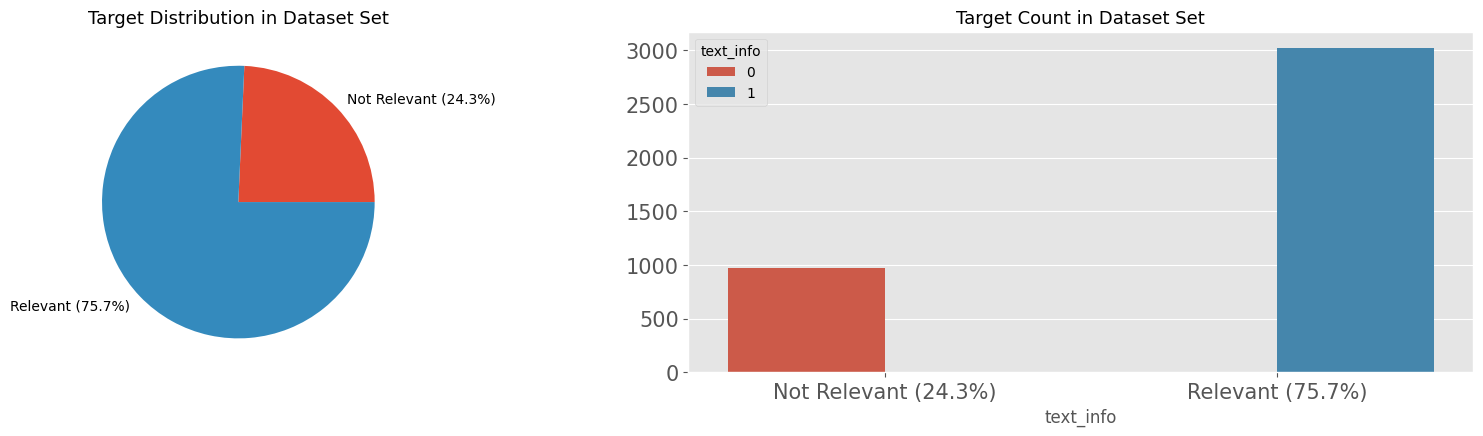

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

tot = Relevant_len + Not_Relevant_len
per1 = str(round(Not_Relevant_len * 100 / tot, 2))
per2 = str(round(Relevant_len * 100 / tot, 2))

tweets_df.groupby('text_info').count()['Tweet Id'].plot(kind='pie', ax=axes[0], labels=[f'Not Relevant ({per1}%)', f'Relevant ({per2}%)'])
sns.countplot(x=tweets_df['text_info'], hue=tweets_df['text_info'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels([f'Not Relevant ({per1}%)', f'Relevant ({per2}%)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Dataset Set', fontsize=13)
axes[1].set_title('Target Count in Dataset Set', fontsize=13)

plt.show()

### Number of characters in tweets

In [ ]:
print(tweets_df['length'].min())
print(tweets_df['length'].max())

41
347


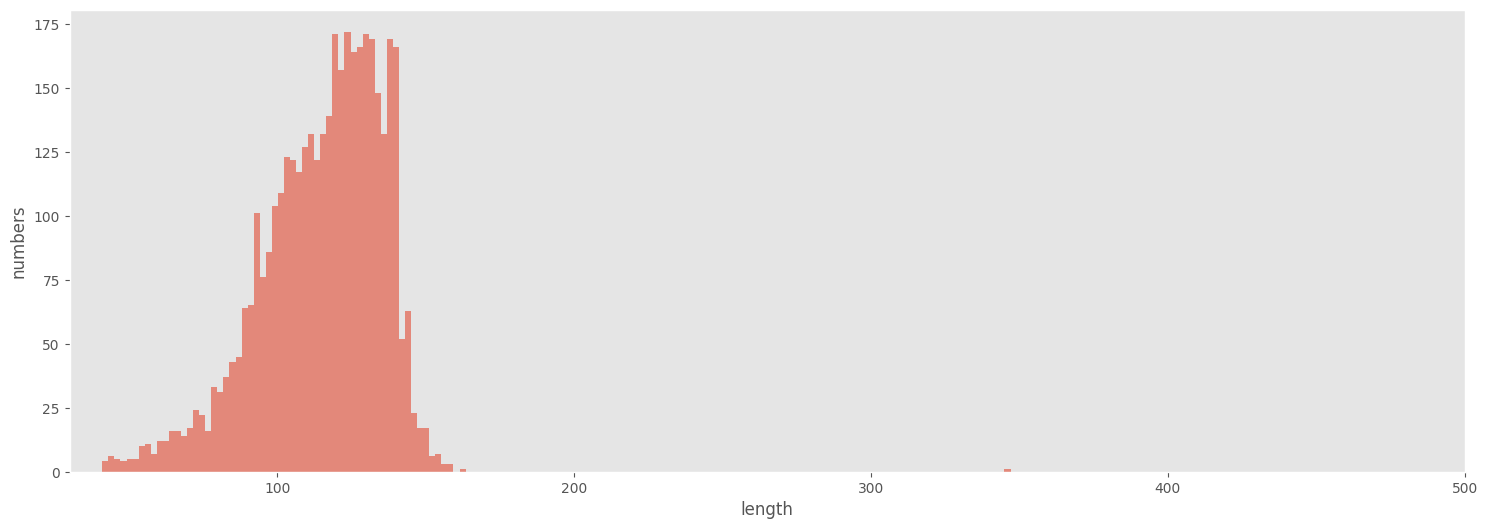

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweets_df['length'], alpha = 0.6, bins=bins)
plt.xlabel('length')
plt.ylabel('numbers')
plt.xlim(30,500)
plt.grid()
plt.show()

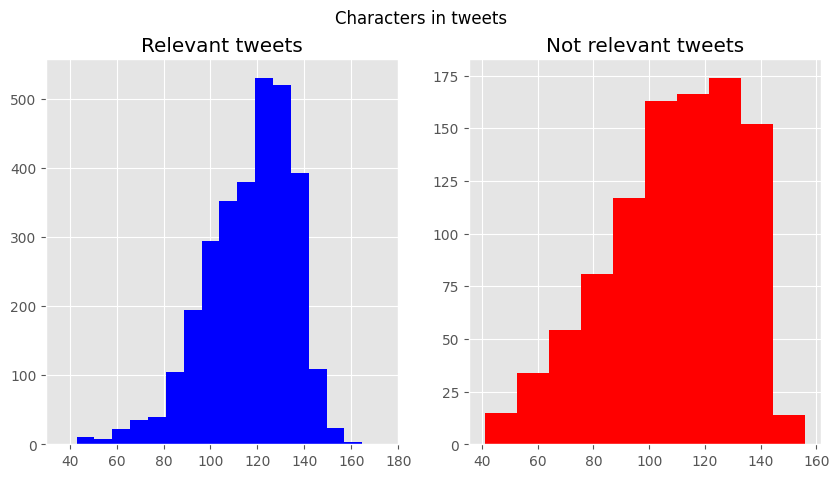

In [ ]:
bins = 40
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweets_df[tweets_df['text_info']==1]['Text'].str.len()
ax1.hist(tweet_len,color='blue', bins = bins)
ax1.set_xlim(30, 180)
ax1.set_title('Relevant tweets')
tweet_len=tweets_df[tweets_df['text_info']==0]['Text'].str.len()
bins = 10
ax2.hist(tweet_len,color='red', bins = bins)
ax2.set_title('Not relevant tweets')
fig.suptitle('Characters in tweets')
plt.show()

### Number of words in a tweet

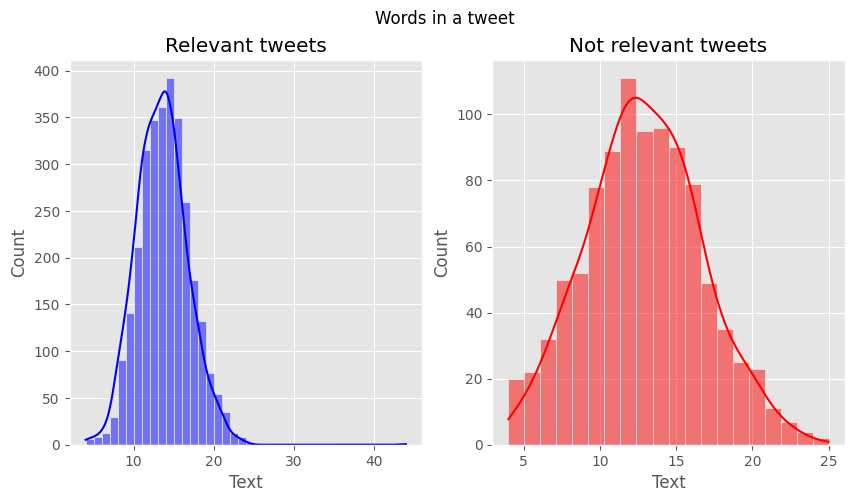

In [ ]:
bins = 40
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweets_df[tweets_df['text_info']==1]['Text'].str.split().map(lambda x: len(x))
sns.histplot(tweet_len,color='blue', bins = bins, ax = ax1, kde=True)
ax1.set_title('Relevant tweets')
tweet_len=tweets_df[tweets_df['text_info']==0]['Text'].str.split().map(lambda x: len(x))
bins = 20
sns.histplot(tweet_len,color='red', bins = bins, ax = ax2, kde=True)
ax2.set_title('Not relevant tweets')
fig.suptitle('Words in a tweet')
plt.show()

### Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

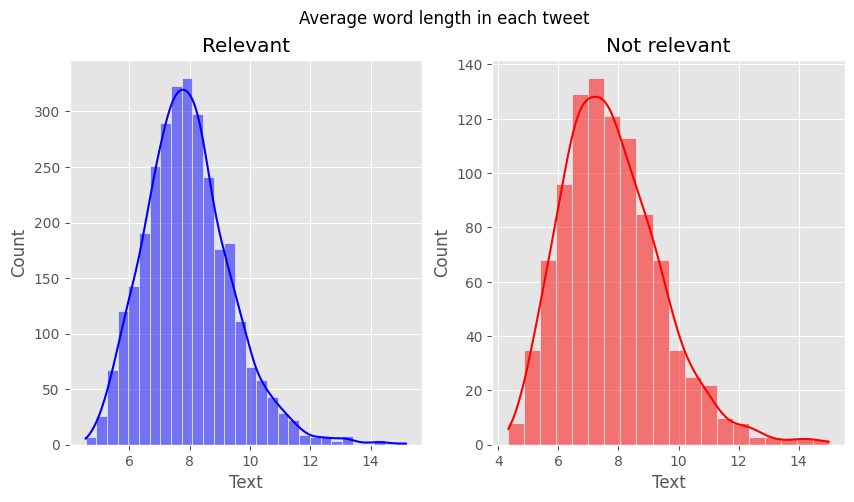

In [ ]:
bins = 30
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweets_df[tweets_df['text_info']==1]['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue', kde=True, bins = bins)
ax1.set_title('Relevant')
word=tweets_df[tweets_df['text_info']==0]['Text'].str.split().apply(lambda x : [len(i) for i in x])
bins = 20
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red', kde=True, bins = bins)
ax2.set_title('Not relevant')
fig.suptitle('Average word length in each tweet')

### Corpus analysis

In [ ]:
def create_corpus(target):
    corpus=[]

    for x in tweets_df[tweets_df['text_info']== target]['Text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
def create_corpus_df(tweets, target):
    corpus=[]

    for x in tweets[tweets['text_info']==target]['Text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus_df_clean(tweets, target):
    corpus=[]

    for x in tweets[tweets['text_info']==target]['Text']:
        for i in x:
            corpus.append(i)
    return corpus


def create_tokenized_df_clean(tweets):
    corpus=[]

    for x in tqdm(tweets['Text']):
        l = []
        for i in x:
            l.append(i)
        corpus.append(l)
    return corpus

### Common stopwords in tweets


Irrelevant tweets

In [ ]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [ ]:
# displaying the stopwords
np.array(stop)

array({'couldn', 'will', 'each', 'shouldn', "shouldn't", 'himself', 'all', 'few', 'mightn', "hadn't", 'hers', 'itself', 'most', 'has', 'his', 'other', 'against', 'not', "haven't", 'can', 'she', 'again', 'they', 'yourself', 'i', "mightn't", 'aren', "it's", 'myself', 'y', 'won', 'over', 'those', "hasn't", 'during', 'too', "that'll", 'at', 'such', 'him', 'through', 'below', 'an', 'weren', 'was', 'does', 'by', 't', "you've", "aren't", 'themselves', 'had', 'ours', 'me', "you'll", 'mustn', 'isn', 'only', 'own', "couldn't", 'should', 'yours', 'no', 'don', 'her', 'into', 'how', 've', 'herself', 'having', 'further', "wouldn't", 'off', 'am', 'theirs', 're', 'm', 'o', 'a', 'these', 'under', 'some', "isn't", 'from', 'do', 'whom', 'down', 'their', 'be', 'with', 'on', 'there', 'after', 'same', "didn't", 'are', 'than', 'as', 'were', 'in', 'while', 'once', 'here', 'where', 'both', 'between', 'because', 'so', 'very', 's', 'have', 'is', 'it', 'and', 'didn', 'ourselves', 'then', 'yourselves', 'hasn', 'sh

<BarContainer object of 10 artists>

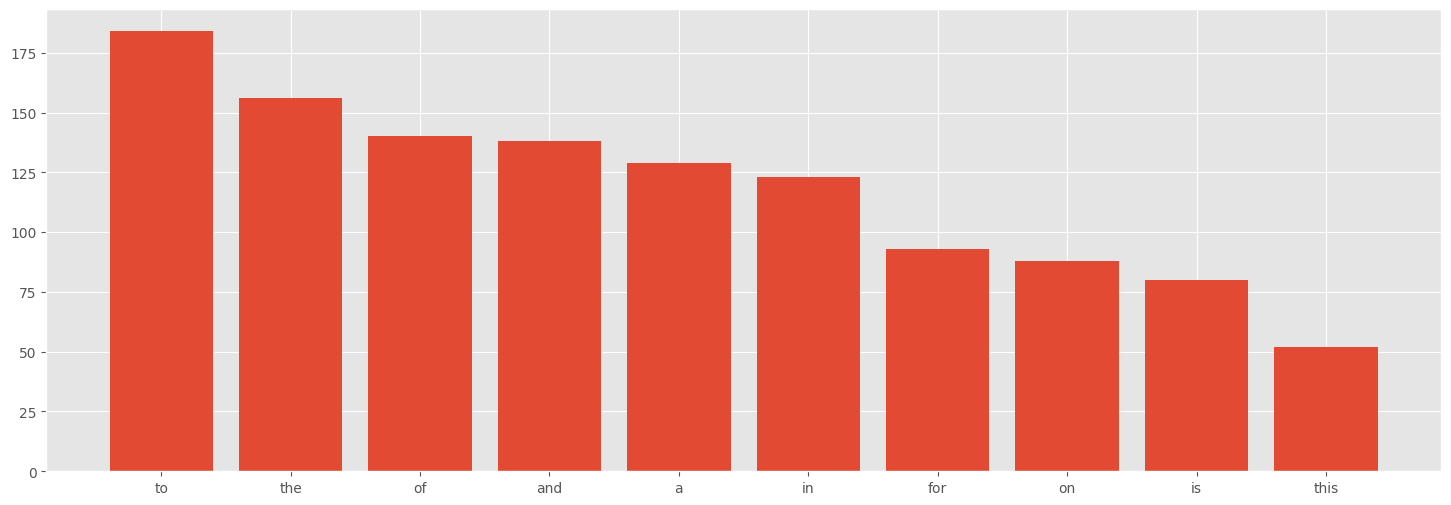

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

Relevant tweets

<BarContainer object of 10 artists>

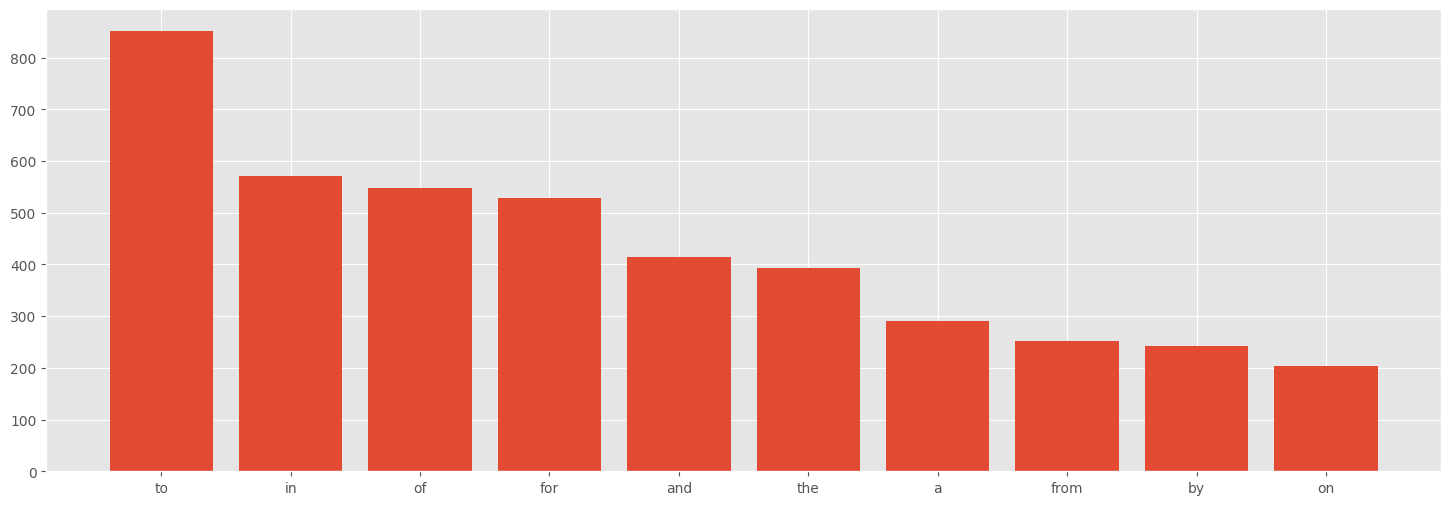

In [ ]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]


plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

### Analyzing punctuations

Relevant tweets

<BarContainer object of 16 artists>

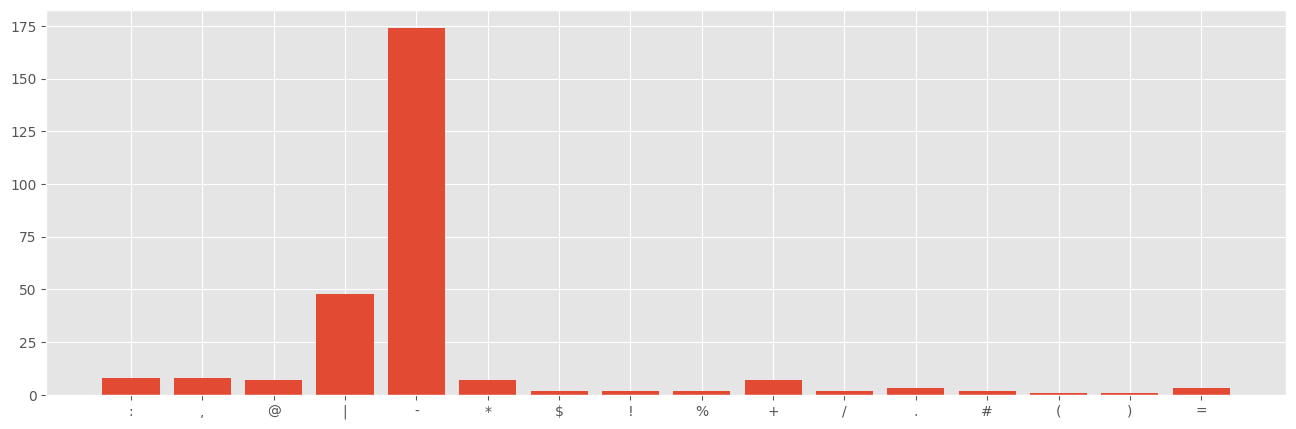

In [ ]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y)

Irrelevant tweets

<BarContainer object of 15 artists>

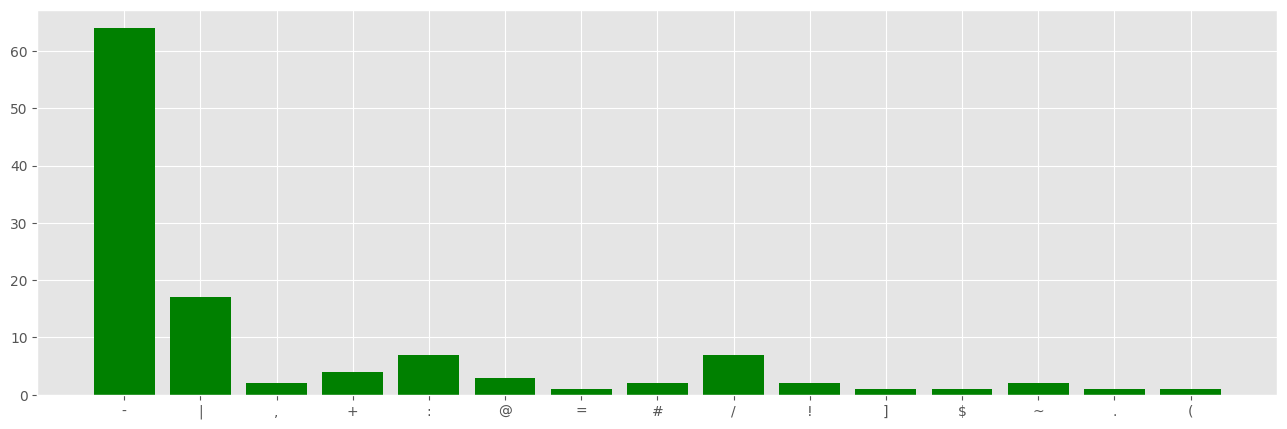

In [ ]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y,color='green')

### Common words

<Axes: >

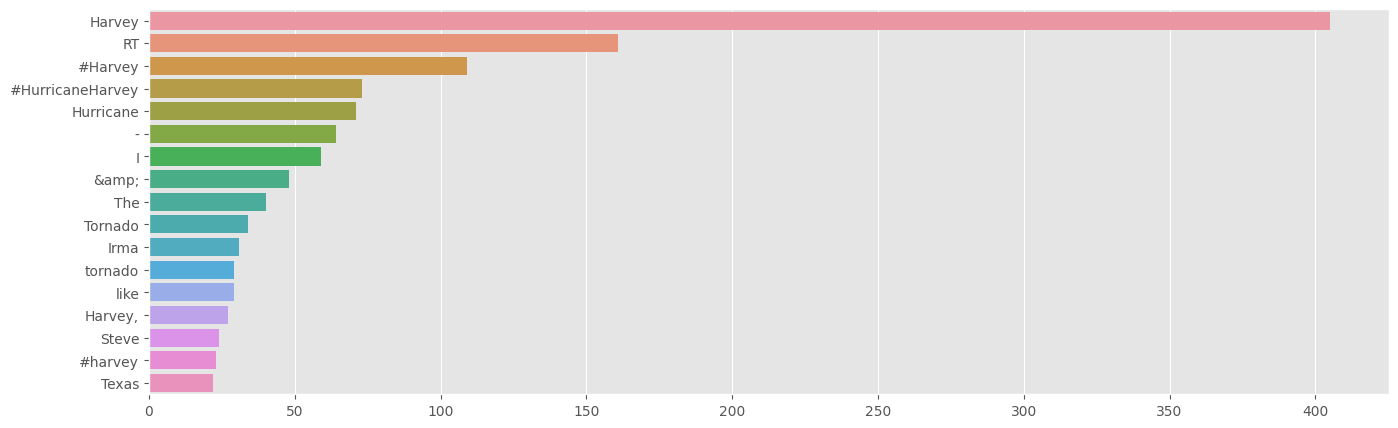

In [ ]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

<Axes: >

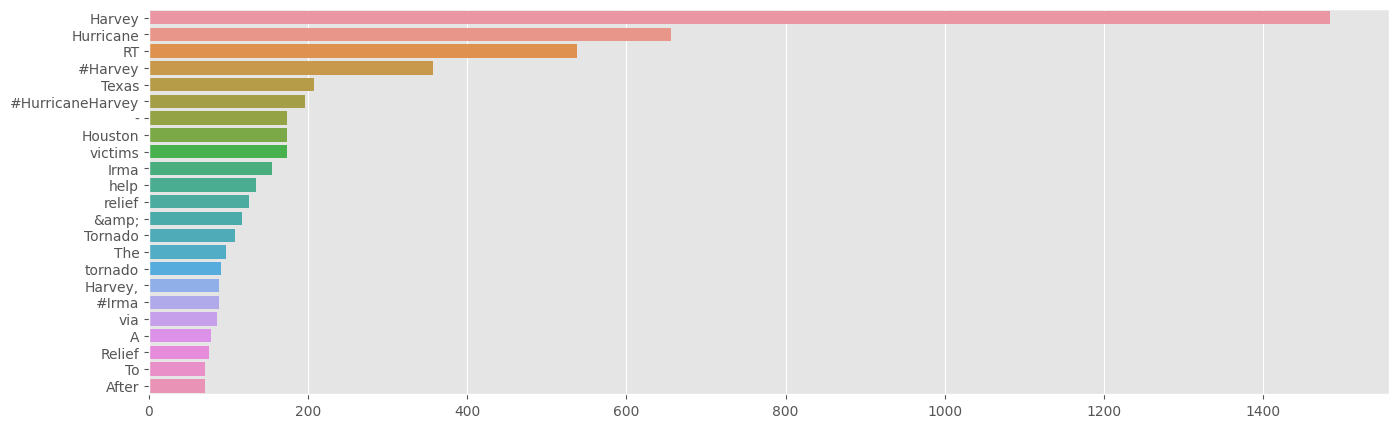

In [ ]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

## Data cleaning functions

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    s =  re.sub(r'\b(?:\w+(?:[-.]\w+)*\.)+\w*(?:[-./]\w*)*(?:/|\b)', '' , sample)
    s = re.sub(r'https?://\S+|www\.\S+|bit\.ly/\S+|t\.co/\S+|ow\.ly/\S+|tinyurl\.com/\S+|is\.gd/\S+|goo\.gl/\S+|ow\.ly/\S+|buff\.ly/\S+|adf\.ly/\S+|ift\.tt/\S+', " ", s)

    s = re.sub(r"http\S+", "", s)

    return s

def remove_HTML(text):
    return re.sub('r<.*?>',' ', text)

def remove_mentions(text):
  return re.sub(r'@\w+',' ',text)

def remove_multiple_spaces(text):
  return re.sub('\s+',  ' ', text)

def remove_RT(words):
    w =  words.replace("RT : ", "")
    w =  w.replace("rt : ", "")
    w = w.replace(" rt ", "")
    return w


def remove_amp(words):
    w =  words.replace("&amp;", "")
    w = w.replace("&lt;", "")
    w = w.replace("&gt;", "")
    w = re.sub('r&.*?;','', w)
    return w.replace(" amp ", "")

def remove_dash(words):
  return words.replace(" - ", "")

def remove_non_ascii(text, remove_emoji = True):
    # Pattern to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)


    #print([c for c in text])
    if remove_emoji:
          text = ''.join(c for c in text if c.isascii())
    else:     # Remove non-ASCII characters except emojis
          text = ''.join(c for c in text if c.isascii() or emoji_pattern.match(c))

    return text

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def convert_space(text):
  text = text.replace(u'\xa0', u' ')
  return text

def remove_harvey(text):
    text = text.replace("harvey ", "")
    text = text.replace("Harvey ", "")
    return text

def remove_newlines(text):
  text = re.sub('\n',   ' ', text)
  return text

def preprocess(sample):
    if isinstance(sample, float):
      return sample
    sample = convert_space(sample)
    sample = remove_multiple_spaces(sample)
    sample = remove_newlines(sample)
    sample = remove_non_ascii(sample)
    sample = remove_URL(sample)
    sample = remove_HTML(sample)
    sample = remove_mentions(sample)
    sample = remove_dash(sample)
    sample = remove_amp(sample)
    #sample = remove_harvey(sample)
    sample = replace_contractions(sample)
    sample = remove_multiple_spaces(sample)
    sample = remove_RT(sample)

    return " ".join(normalize(sample.split(" ")))

def preprocess_for_bert(sample):
  if isinstance(sample, float):
    return sample
  sample = convert_space(sample)
  sample = remove_multiple_spaces(sample)
  sample = remove_newlines(sample)
  sample = remove_URL(sample)
  sample = remove_HTML(sample)
  sample = remove_mentions(sample)
  sample = remove_dash(sample)
  sample = remove_amp(sample)
  sample = remove_non_ascii(sample, remove_emoji=False)
  #sample = remove_harvey(sample)
  sample = replace_contractions(sample)
  sample = remove_multiple_spaces(sample)
  sample = remove_RT(sample)
  return sample

### Try cleaning results

In [ ]:
tweets_df_clean = tweets_df.copy()
tweets_df_clean['Text'] = tweets_df['Text'].apply(lambda x: preprocess(x))

In [ ]:
if show_infos:
  print(tweets_df_clean['Text'])
  print(tweets_df_clean.info())
  print(tweets_df["Text"][3000])
  print(tweets_df_clean["Text"][3000])

0       ajwamood harvey first major hurricane strike u...
1       always good city shows severe weather map hurr...
2       side side satellite images compare size hurric...
3       street se houston river light lightning 10pm h...
4       texas countys long recovery hurricane harvey b...
                              ...                        
3987    thatevvlife sugar sale cafeteria benefits trac...
3988    lol hurricaneharvey fixing kill us like suppos...
3989    harvey got busy footballing week football twic...
3990                       wet resist harvey presidential
3991    delivered relief efforts rockport today thanks...
Name: Text, Length: 3992, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3992 entries, 0 to 3991
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0.2   3992 non-null   Int64 
 1   Unnamed: 0     3992 non-null   Int64 
 2   Unnamed: 0.1   3992 non-null   Int64 


## Basic Statistics

In [ ]:
tweets_df['word_count'] = tweets_df['Text'].apply(lambda x: len(str(x).split()))
tweets_df['unique_word_count'] = tweets_df['Text'].apply(lambda x: len(set(str(x).split())))
tweets_df['stop_word_count'] = tweets_df['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))
tweets_df['url_count'] = tweets_df['Text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
tweets_df['mean_word_length'] = tweets_df['Text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
tweets_df['char_count'] = tweets_df['Text'].apply(lambda x: len(str(x)))

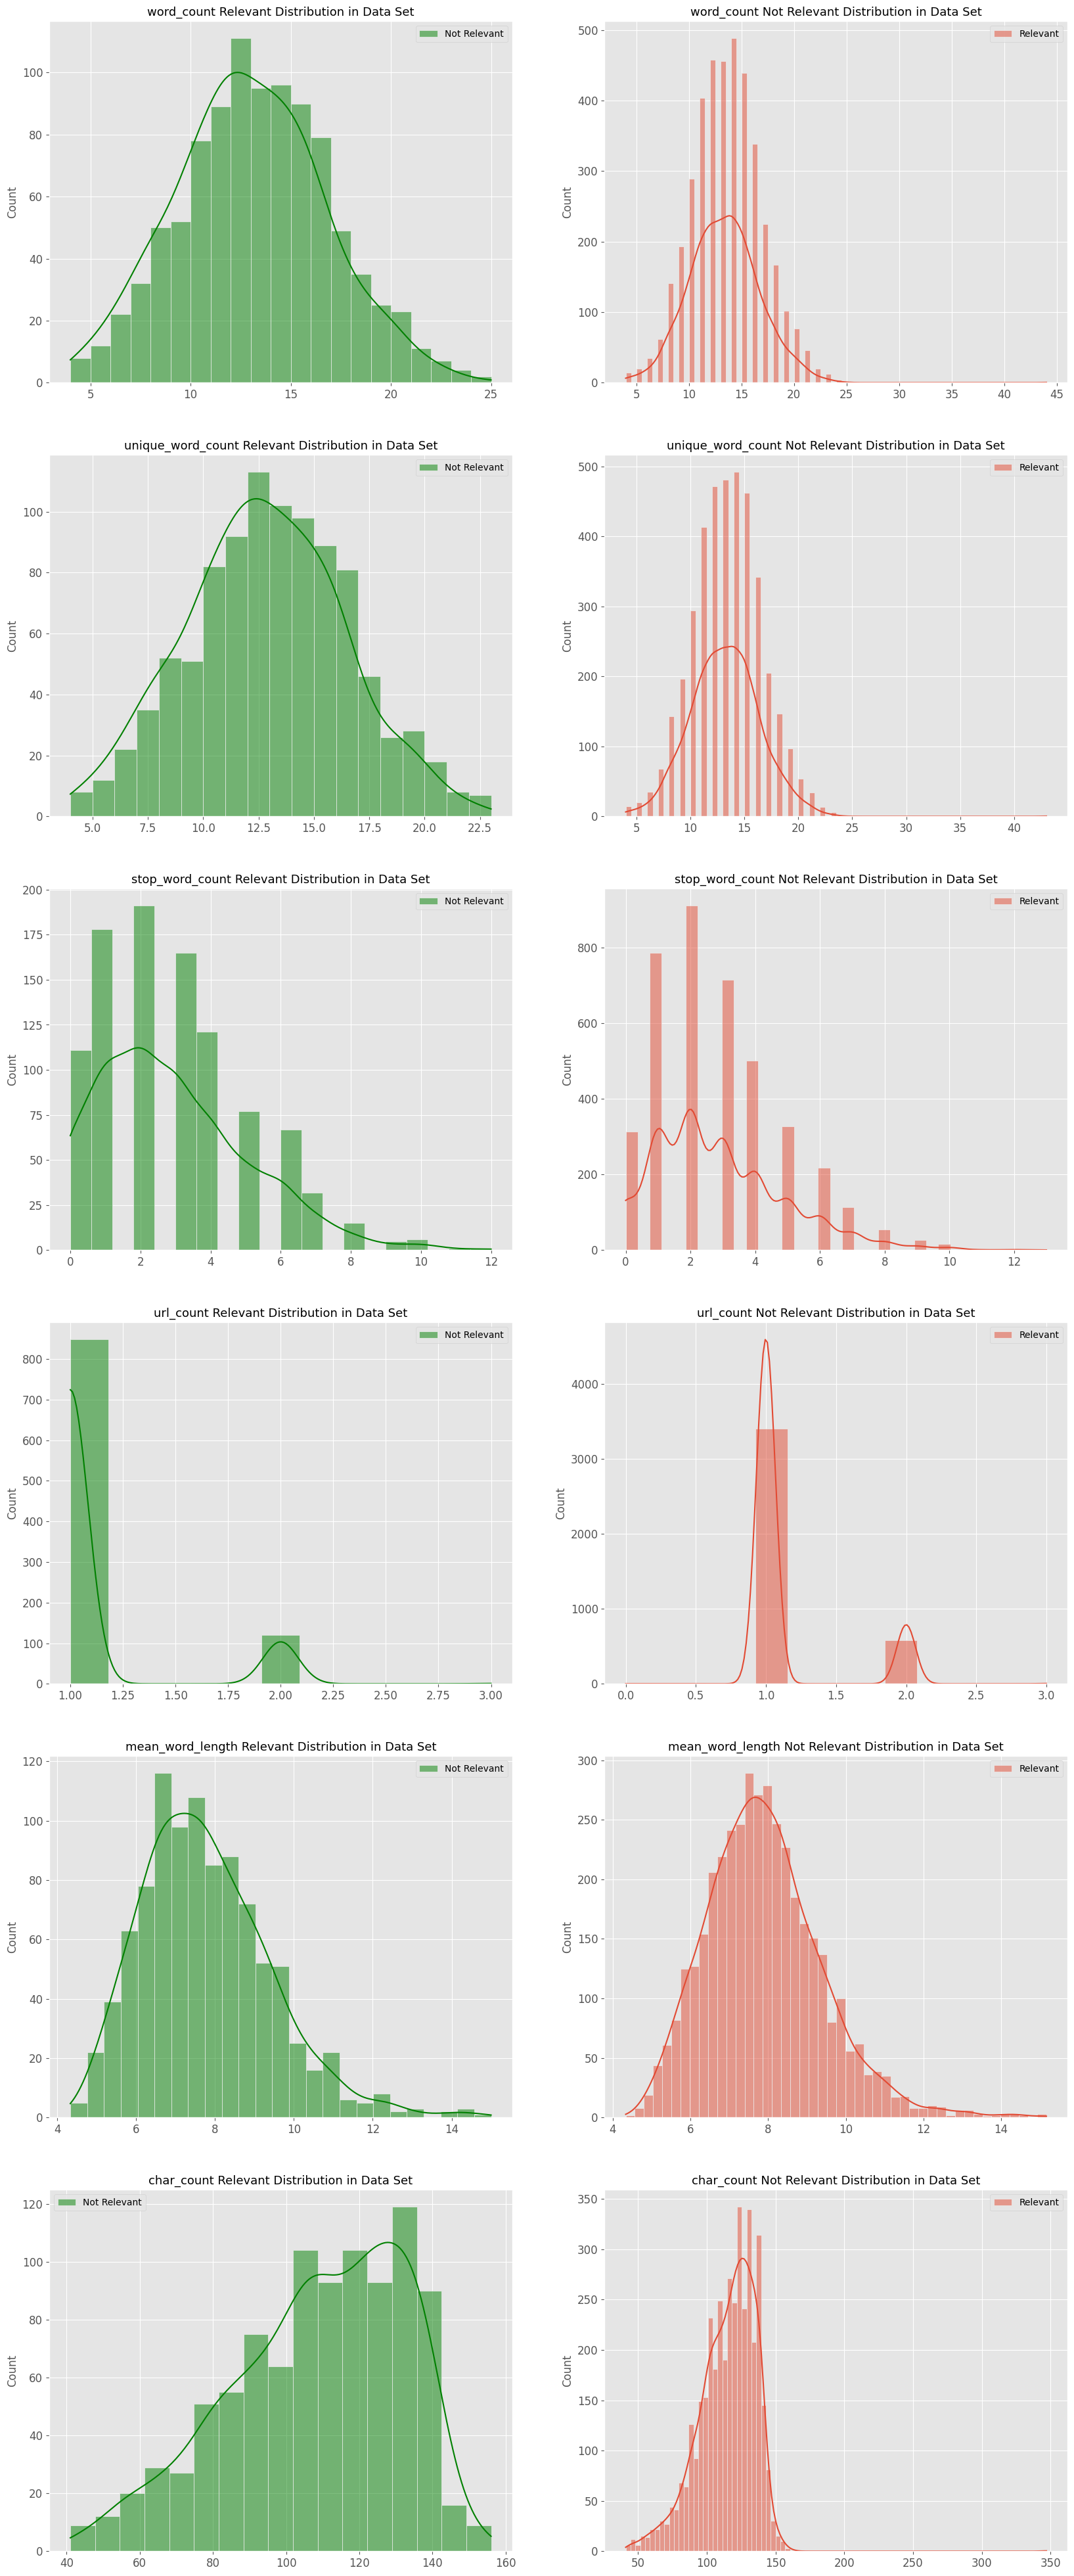

In [ ]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = tweets_df['text_info'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(tweets_df.loc[~DISASTER_TWEETS][feature], label='Not Relevant', ax=axes[i][0], color='green', kde=True)

    sns.histplot(tweets_df[feature], ax=axes[i][1], label='Relevant',  kde=True)

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Relevant Distribution in Data Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Not Relevant Distribution in Data Set', fontsize=13)

plt.show()

## Word Cloud - common words

Relevant

In [ ]:
corpus_all_relev = create_corpus_df_clean(tweets_df,1)

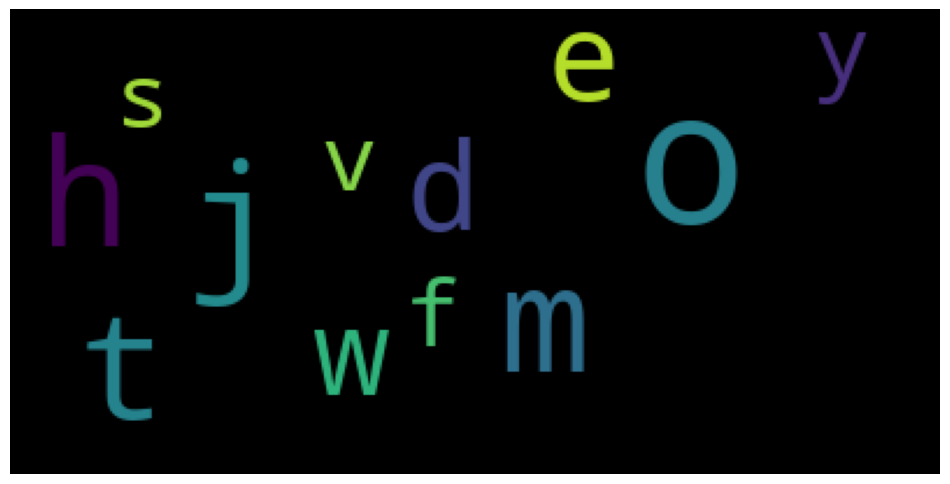

In [ ]:
# Generating the wordcloud with the values
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',
                       max_font_size = 80).generate(" ".join(corpus_all_relev[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

<Axes: >

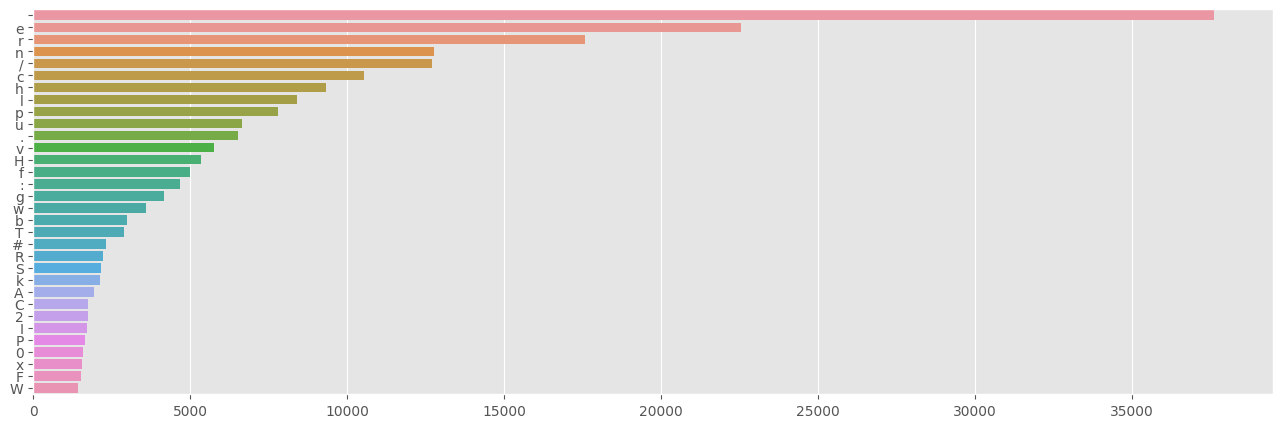

In [ ]:
plt.figure(figsize=(16,5))
counter=Counter(corpus_all_relev)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

Not relevant

In [ ]:
corpus_all_irrelev = create_corpus_df_clean(tweets_df,0)

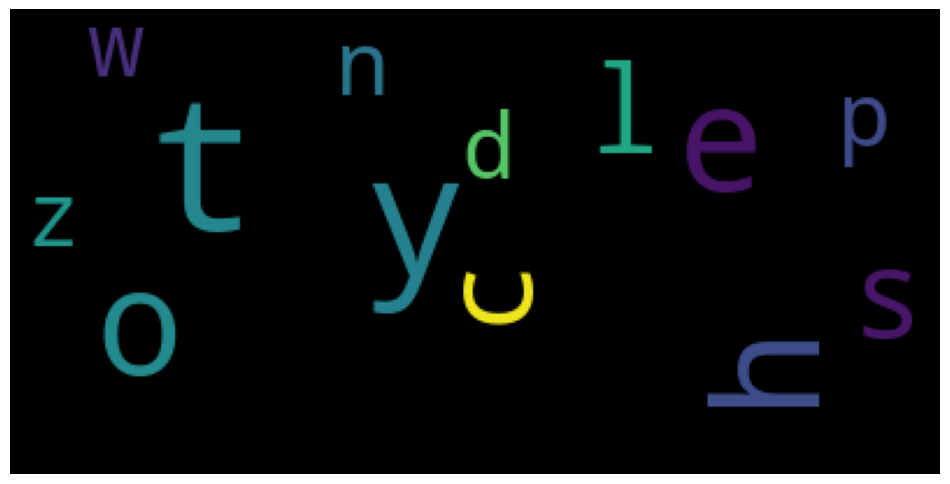

In [ ]:
# Generating the wordcloud with the values
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_all_irrelev[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

<Axes: >

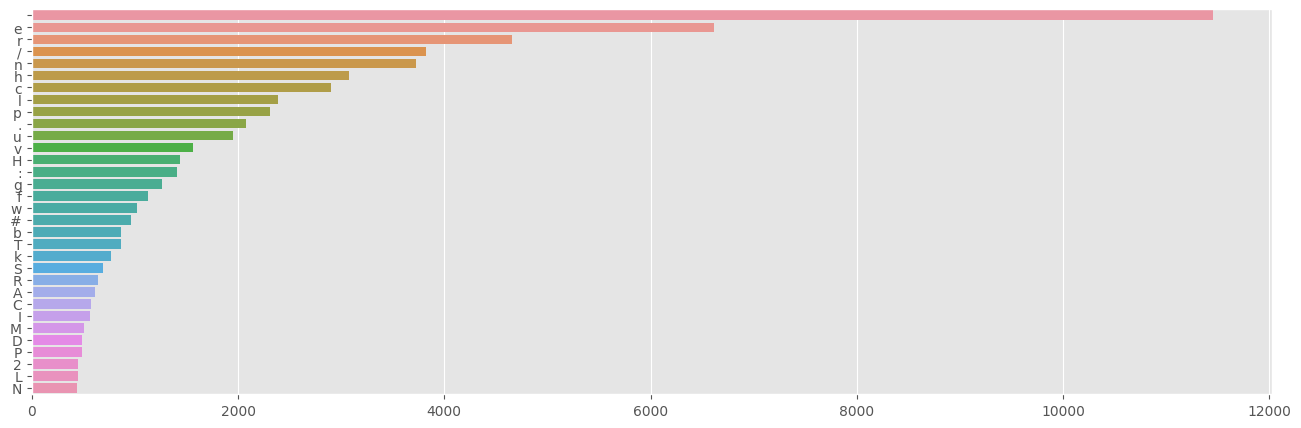

In [ ]:
plt.figure(figsize=(16,5))
counter=Counter(corpus_all_irrelev)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

In [ ]:
compare = False

if compare:
  print(corpus_all_relev[:50])
  print(corpus_all_irrelev[:50])

## Bag of Words Counts

In [ ]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = tweets_df["Text"].tolist()
list_labels = tweets_df["text_info"].tolist()

samples_counts, count_vectorizer = cv(list_corpus)

### Visualizing the embeddings

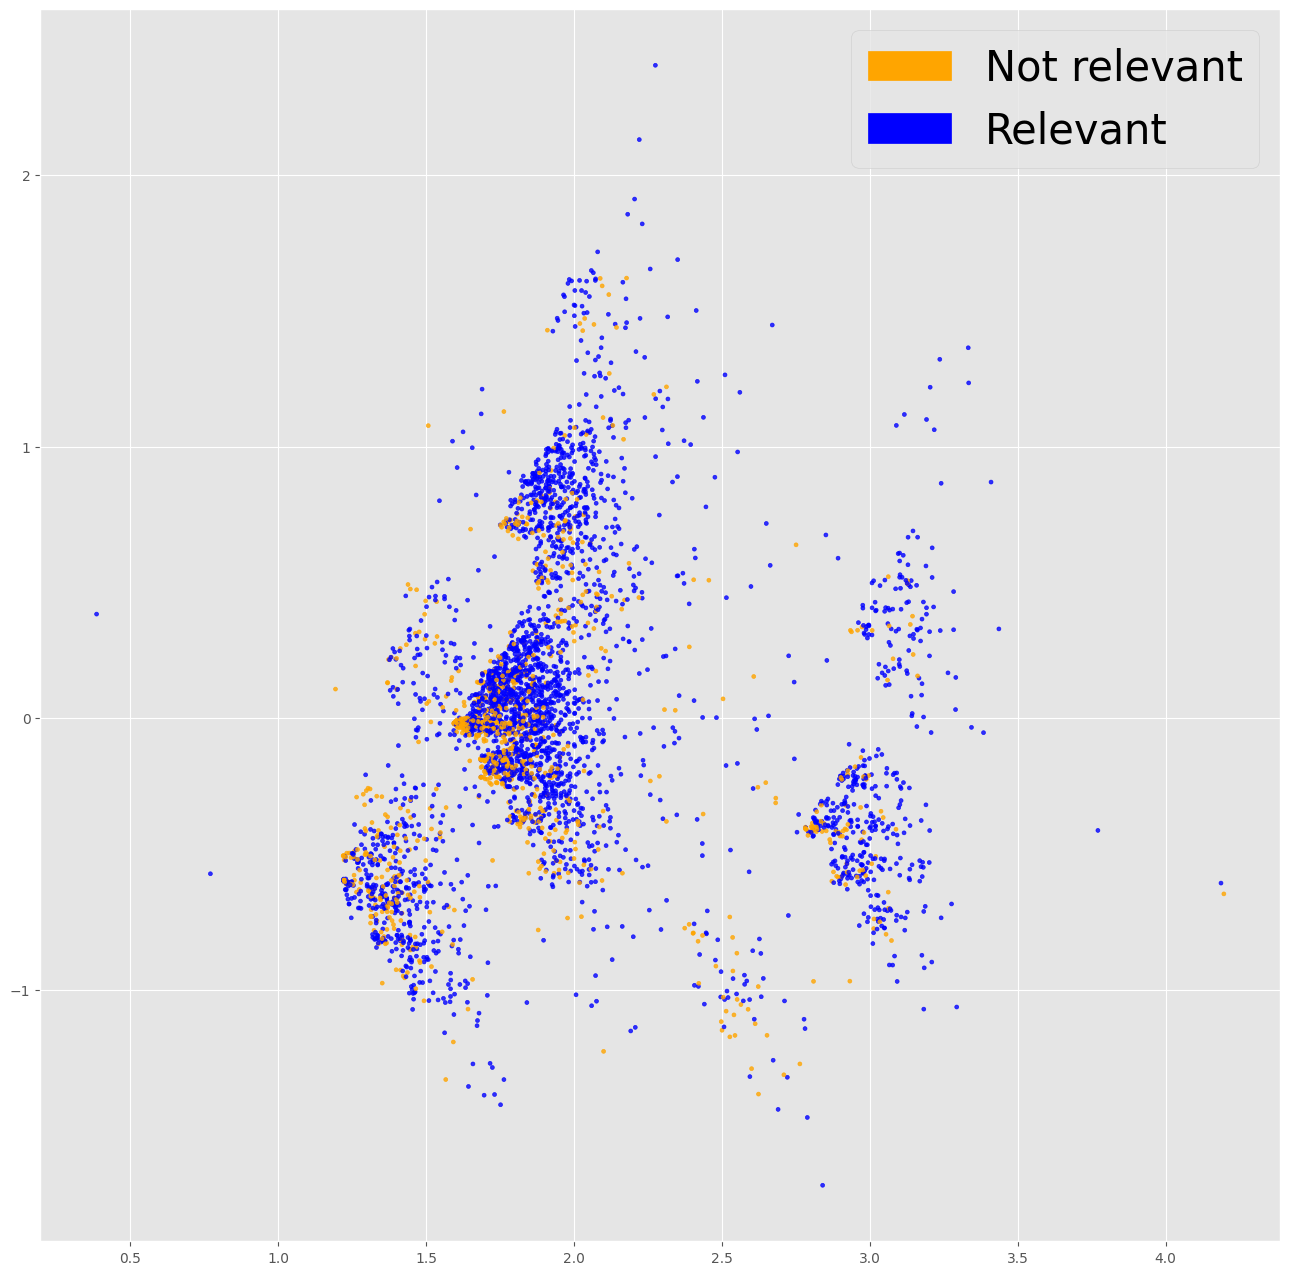

In [ ]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not relevant')
            blue_patch = mpatches.Patch(color='blue', label='Relevant')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))
plot_LSA(samples_counts, list_labels)
plt.show()

These embeddings don't look very cleanly separated :(

## TF IDF

In [ ]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

samples_tfidf, tfidf_vectorizer = tfidf(list_corpus)

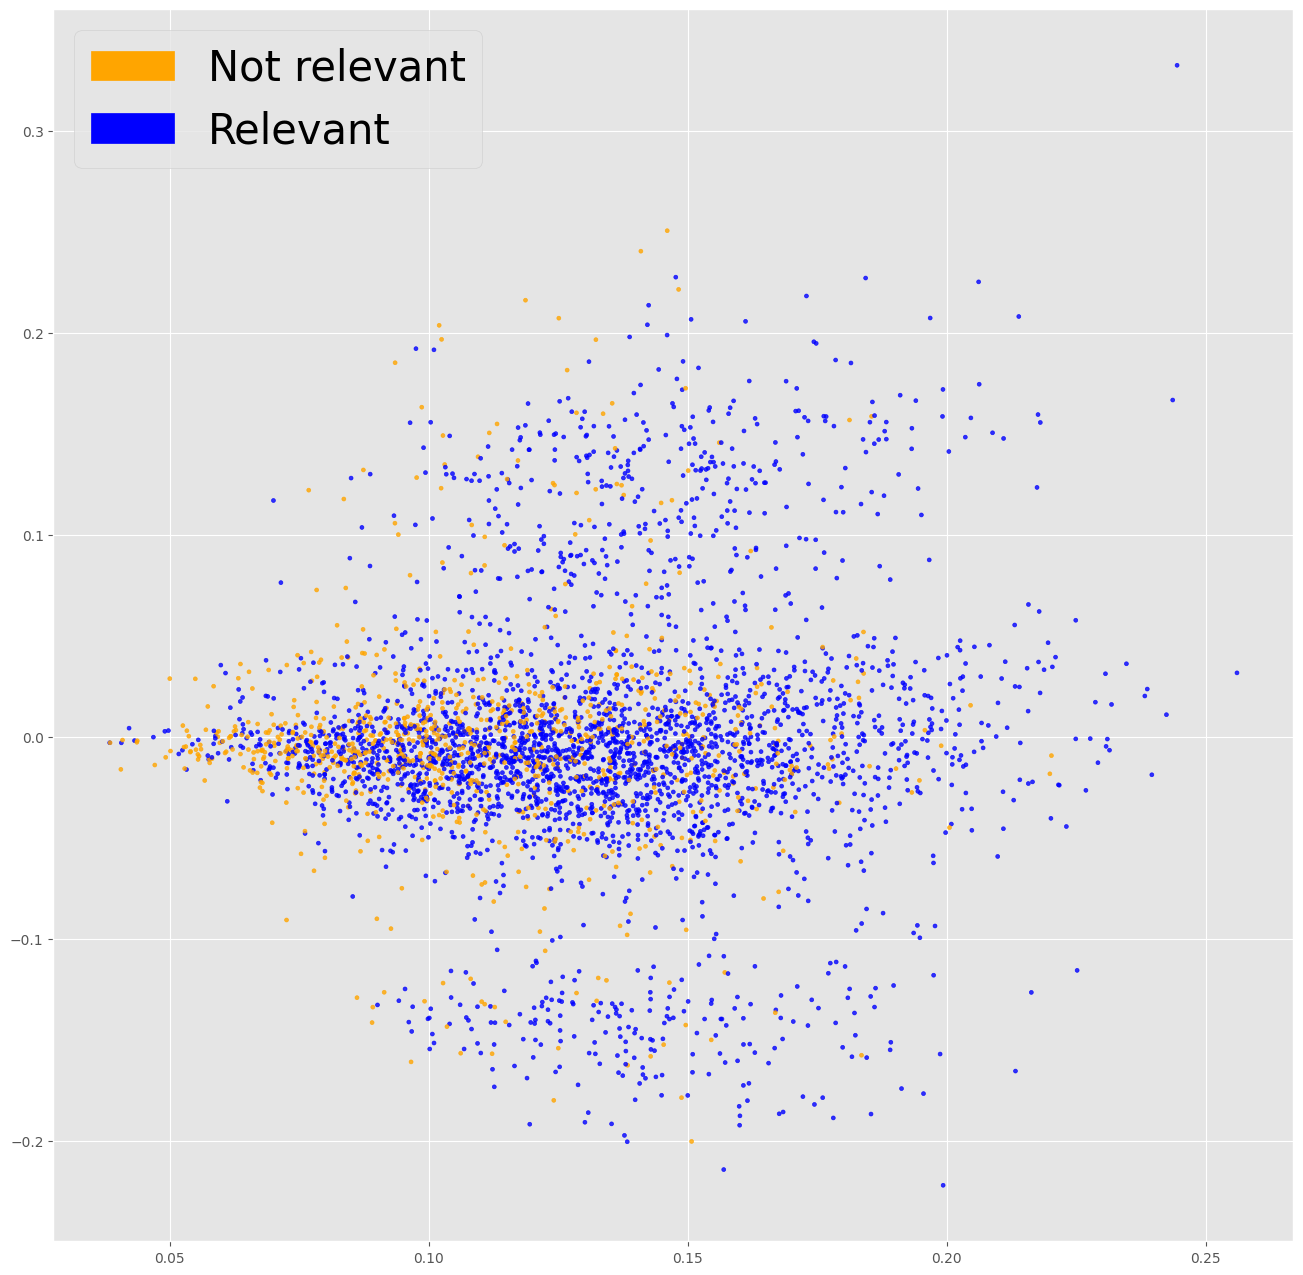

In [ ]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(samples_tfidf, list_labels)
plt.show()

# save functions

In [ ]:
class NumpyFloatValuesEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return JSONEncoder.default(self, obj)


def save_history(history, path, name):
  p = os.path.join(path, name+"_history.json")
  with open(p, 'w') as file_pi:
    json.dump(history.history, file_pi, cls=NumpyFloatValuesEncoder)
  return p

def save_cm(path, name,cm):
  p = os.path.join(path, name+"_cm.csv")
  cm.to_csv(p)
  return p

def plot_cm(cm, normalize_cm = False, cbar = True):
  if normalize_cm:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  s = sns.heatmap(square = False, cbar = cbar, data=cm, annot=True,  annot_kws={"size":30}, linewidth=.5, fmt='g', xticklabels=['Not Relevant', 'Relevant'], yticklabels=['Not Relevant', 'Relevant'])
  s.set(xlabel='True Values', ylabel='Predicted Values')

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})

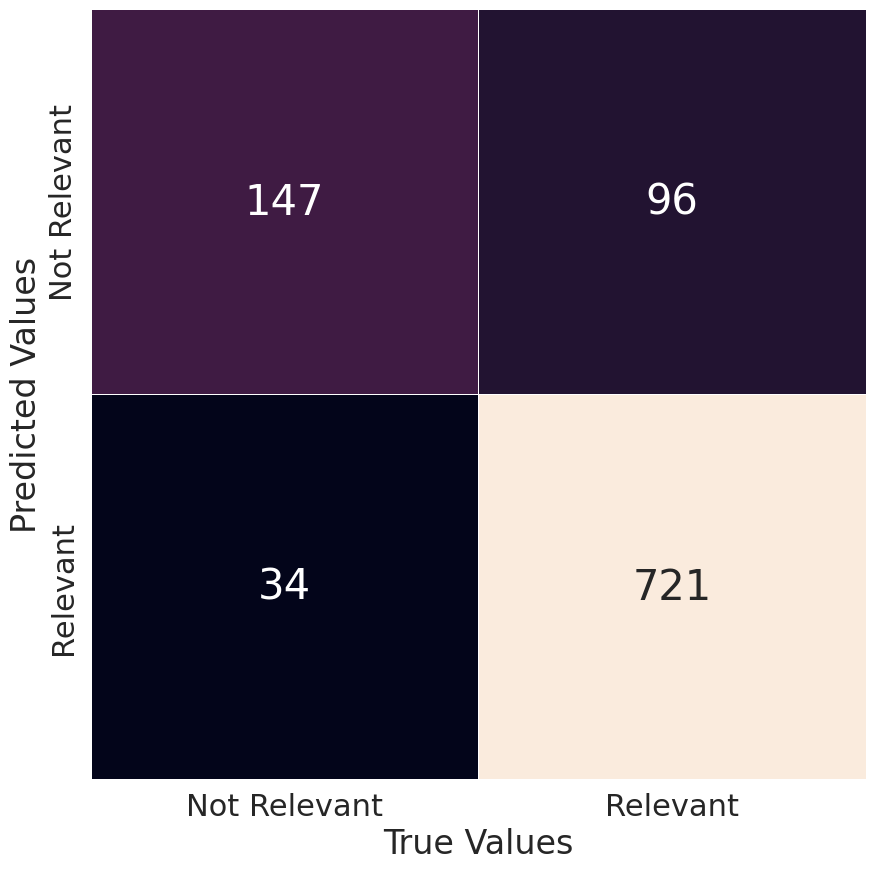

In [ ]:
cm = [[147, 96], [34, 721]]
sns.set(font_scale=2)
plot_cm(cm, normalize_cm = False, cbar=False)

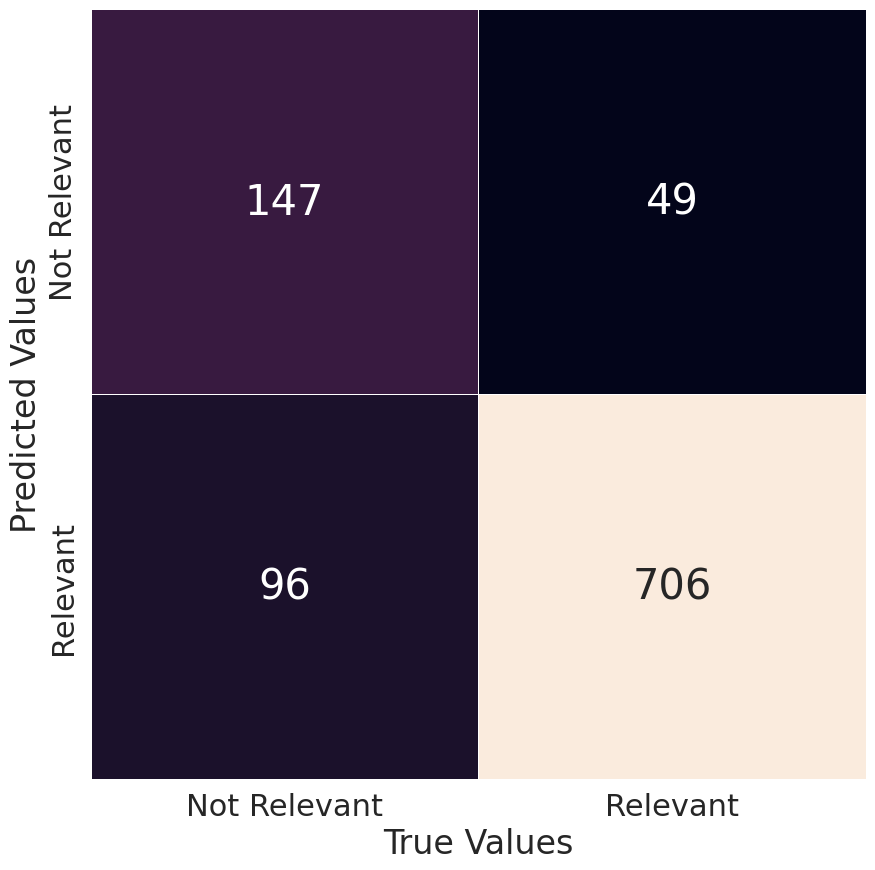

In [ ]:
cm = [[147, 96], [34, 721]]
plot_cm(cm, normalize_cm = False, cbar=False)

# Preprocess data

In [ ]:
tweets_df_clean = tweets_df.copy()
tweets_df_clean['Text Clean Bert'] = tweets_df_clean['Text'].apply(lambda x: preprocess_for_bert(x))
tweets_df_clean['Ext Text Clean Bert']= tweets_df_clean['Ext Text'].apply(lambda x: preprocess_for_bert(x))
tweets_df_clean['Ext Text S1 Clean Bert'] = tweets_df['Ext Text S1'].apply(lambda x: preprocess_for_bert(x))
tweets_df_clean['Ext Text S2 Clean Bert'] = tweets_df['Ext Text S2'].apply(lambda x: preprocess_for_bert(x))

tweets_df_clean['Text Clean Glove'] = tweets_df_clean['Text'].apply(lambda x: preprocess(x))
tweets_df_clean['Ext Text Clean Glove']= tweets_df_clean['Ext Text'].apply(lambda x: preprocess(x))
tweets_df_clean['Ext Text S1 Clean Glove'] = tweets_df['Ext Text S1'].apply(lambda x: preprocess(x))
tweets_df_clean['Ext Text S2 Clean Glove'] = tweets_df['Ext Text S2'].apply(lambda x: preprocess(x))

# Trainings with CrisisMMD clean


In [ ]:
random_state_split = seed
learning_rate = 5e-4

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

epochs_num = 30
batch_size_num = 16

## Baseline GloVe model



In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['Text Clean Glove']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

In [ ]:
corpus_clean=create_corpus_new(tweets_df_clean)

  0%|          | 0/3992 [00:00<?, ?it/s]

In [ ]:
if show_infos:
  print(corpus_clean)
  print(len(corpus_clean))

[['ajwamood', 'harvey', 'first', 'major', 'hurricane', 'strike', 'us', 'since', '2005', 'causes', 'least', '1', 'fatality'], ['always', 'good', 'city', 'shows', 'severe', 'weather', 'map', 'hurricaneharvey', 'itaintoveryet'], ['side', 'side', 'satellite', 'images', 'compare', 'size', 'hurricane', 'harvey', 'hurricane', 'katrina', '2005'], ['street', 'se', 'houston', 'river', 'light', 'lightning', '10pm', 'harvey'], ['texas', 'countys', 'long', 'recovery', 'hurricane', 'harvey', 'begins'], ['showers', 'harvey', 'possible', 'midlate', 'week', 'n', 'ga', 'latest', 'harvey', '6am'], ['photos', 'show', 'devastation', 'left', 'behind', 'hurricane', 'harvey'], ['photo', 'meyerland', 'area', 'southwest', 'houston', 'shared', 'resident', 'houwx', 'harvey'], ['meanwhile', 'houston', 'car', 'chance', 'bro', 'harvey'], ['really', 'tornado', 'crazy'], ['flooding', 'begins', 'worst', 'ts', 'harveys', 'moisture', 'moves', 'houston'], ['wild', 'video', 'hawk', 'hitches', 'ride', 'houston', 'cab', 'har

### Try clean corpus

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
embedding_dict={}
with open('./data/glove.twitter.27B.200d.txt','r') as f:
    for idx, line in tqdm(enumerate(f)):
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

embedding_dim = 200

0it [00:00, ?it/s]

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus_clean)
sequences=tokenizer_obj.texts_to_sequences(corpus_clean)
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 8428


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,embedding_dim))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec

  0%|          | 0/8428 [00:00<?, ?it/s]

In [ ]:
model=Sequential()

embedding=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=tf.keras.optimizers.experimental.AdamW(learning_rate=learning_rate, jit_compile=False)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 50, 200)           1685800   
                                                                 
 spatial_dropout1d_29 (Spati  (None, 50, 200)          0         
 alDropout1D)                                                    
                                                                 
 lstm_29 (LSTM)              (None, 256)               467968    
                                                                 
 dense_29 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,154,025
Trainable params: 468,225
Non-trainable params: 1,685,800
_________________________________________________________________


In [ ]:
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(
    tweet_pad,
    tweets_df_clean['text_info'].values,
    test_size=1 - train_ratio, shuffle=True, random_state = seed, stratify=tweets_df_clean['text_info'].values)

In [ ]:
X_train_pad, X_val_pad, y_train_pad, y_val_pad = train_test_split(
    X_train_pad, y_train_pad, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=True, random_state = seed, stratify=y_train_pad)

In [ ]:
es = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Recomended 10-20 epochs
history=model.fit(X_train_pad,y_train_pad,batch_size=128,epochs=epochs_num,validation_data=(X_val_pad,y_val_pad), callbacks = [es])

Epoch 1/30
15/15 [==============================] - 10s 398ms/step - loss: 0.6061 - accuracy: 0.7494 - val_loss: 0.5166 - val_accuracy: 0.7571
Epoch 2/30
15/15 [==============================] - 3s 213ms/step - loss: 0.4608 - accuracy: 0.7790 - val_loss: 0.4882 - val_accuracy: 0.8322
Epoch 3/30
15/15 [==============================] - 3s 217ms/step - loss: 0.4124 - accuracy: 0.8385 - val_loss: 0.4381 - val_accuracy: 0.8306
Epoch 4/30
15/15 [==============================] - 6s 389ms/step - loss: 0.3966 - accuracy: 0.8369 - val_loss: 0.3992 - val_accuracy: 0.8347
Epoch 5/30
15/15 [==============================] - 5s 304ms/step - loss: 0.3744 - accuracy: 0.8474 - val_loss: 0.4050 - val_accuracy: 0.8356
Epoch 6/30
15/15 [==============================] - 3s 216ms/step - loss: 0.3702 - accuracy: 0.8441 - val_loss: 0.4033 - val_accuracy: 0.8205
Epoch 7/30
15/15 [==============================] - 3s 222ms/step - loss: 0.3657 - accuracy: 0.8519 - val_loss: 0.4406 - val_accuracy: 0.8372
Epoch

In [ ]:
preds = model.predict(X_test_pad)
preds = (preds > 0.5).astype(int)
cm = confusion_matrix(preds, y_test_pad)

32/32 [==============================] - 1s 16ms/step


In [ ]:
cr = classification_report(preds, y_test_pad, output_dict=True)

In [ ]:
display(cr)

{'0': {'precision': 0.5349794238683128,
  'recall': 0.7428571428571429,
  'f1-score': 0.6220095693779905,
  'support': 175},
 '1': {'precision': 0.9403973509933775,
  'recall': 0.8626974483596598,
  'f1-score': 0.899873257287706,
  'support': 823},
 'accuracy': 0.8416833667334669,
 'macro avg': {'precision': 0.7376883874308451,
  'recall': 0.8027772956084014,
  'f1-score': 0.7609414133328483,
  'support': 998},
 'weighted avg': {'precision': 0.8693070331107258,
  'recall': 0.8416833667334669,
  'f1-score': 0.8511496647183671,
  'support': 998}}

In [ ]:
with open("./training_info/glove_report.json", 'w') as file_pi:
  json.dump(cr, file_pi, cls=NumpyFloatValuesEncoder)

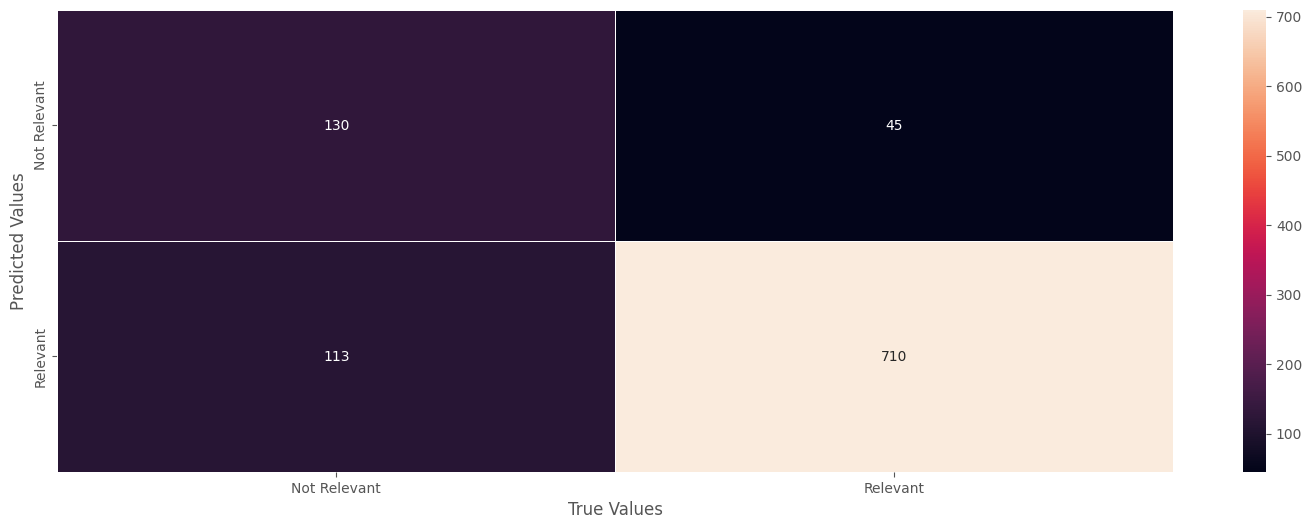

In [ ]:
p = save_history(history = history, path = "./training_info", name="glove")
c = save_cm(path = "./training_info", cm = cm, name='glove')
plot_cm(cm, normalize_cm = False)



## Bert data preparation

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(tweets_df_clean['Text Clean Bert'].values,
                                               tweets_df_clean['text_info'].values,
                                               test_size=1-train_ratio,
                                               shuffle=True,
                                               random_state = seed,
                                               stratify =                                                tweets_df_clean['text_info'].values)

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,
                                             test_size=test_ratio/(test_ratio + validation_ratio),
                                             shuffle=True, random_state = seed,
                                             stratify=y_train)

## Bert base uncased

1.   Load the model (this time we'll try DistilBERT, which is a smaller transformer model)

In [ ]:
MODEL_NAME = 'bert-base-uncased'
transformer = text.Transformer('bert-base-uncased' , maxlen=MAX_LEN, classes=['Not Relevant','Relevant'])

2. Process the training/test data

In [ ]:
processed_train = transformer.preprocess_train(X_train, y_train)
processed_val = transformer.preprocess_test(X_val, y_val)
processed_test = transformer.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 11
	95percentile : 18
	99percentile : 20


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 17
	99percentile : 20


preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 17
	99percentile : 20


3. Create a model and learner

In [ ]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)

In [ ]:
display(model.summary())

Model: "tf_bert_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_379 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


None

Next, we call the lr_find and lr_plot methods to help identify a good learning rate.

In [ ]:
learner.lr_find(max_epochs=15)

simulating training for different learning rates... this may take a few moments...
Epoch 1/15
224/224 [==============================] - 72s 134ms/step - loss: 0.6217 - accuracy: 0.7104
Epoch 2/15
224/224 [==============================] - 30s 135ms/step - loss: 0.5125 - accuracy: 0.7584
Epoch 3/15
224/224 [==============================] - 30s 132ms/step - loss: 0.4018 - accuracy: 0.8171
Epoch 4/15
224/224 [==============================] - 29s 129ms/step - loss: 0.3065 - accuracy: 0.8725
Epoch 5/15
224/224 [==============================] - 30s 132ms/step - loss: 0.2699 - accuracy: 0.8960
Epoch 6/15
224/224 [==============================] - 29s 131ms/step - loss: 0.3193 - accuracy: 0.8826
Epoch 7/15
224/224 [==============================] - 29s 129ms/step - loss: 0.5906 - accuracy: 0.7388
Epoch 8/15
224/224 [==============================] - 29s 129ms/step - loss: 0.6176 - accuracy: 0.7427
Epoch 9/15
224/224 [==============================] - 30s 133ms/step - loss: 0.6798 - accurac

Invoke the larner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.

Three possible suggestions for LR from plot:
	Longest valley (red): 2.82E-06
	Min numerical gradient (purple): 3.34E-06
	Min loss divided by 10 (omitted from plot): 3.73E-06


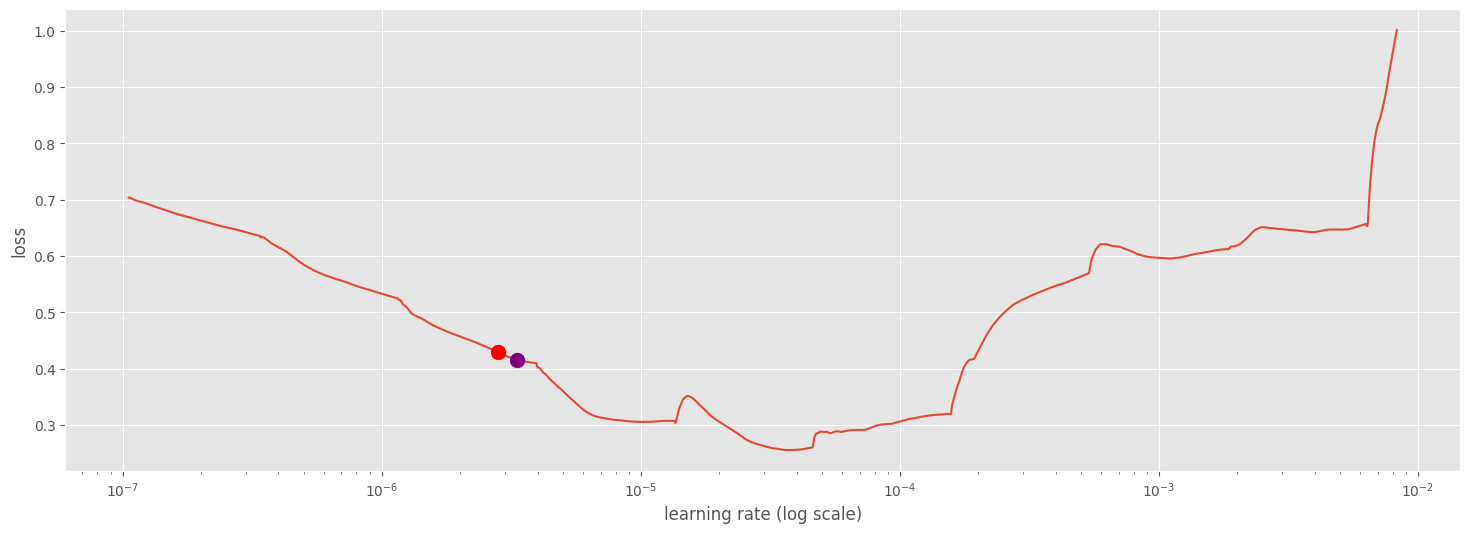

In [ ]:
learner.lr_plot(suggest=True) # batch size 64

In [ ]:
history = learner.autofit(3.73E-06, checkpoint_folder='./weights/bert_base/', monitor = 'val_accuracy')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 3.73e-06...
Epoch 1/1024
225/225 [==============================] - 73s 210ms/step - loss: 0.4317 - accuracy: 0.8129 - val_loss: 0.3727 - val_accuracy: 0.8406
Epoch 2/1024
225/225 [==============================] - 46s 205ms/step - loss: 0.3088 - accuracy: 0.8786 - val_loss: 0.3647 - val_accuracy: 0.8564
Epoch 3/1024
225/225 [==============================] - 49s 216ms/step - loss: 0.2523 - accuracy: 0.9037 - val_loss: 0.3699 - val_accuracy: 0.8523
Epoch 4/1024
225/225 [==============================] - 44s 196ms/step - loss: 0.2017 - accuracy: 0.9337 - val_loss: 0.3840 - val_accuracy: 0.8573
Epoch 5/1024
225/225 [==============================] - 44s 197ms/step - loss: 0.1705 - accuracy: 0.9477 - val_loss: 0.4029 - val_accuracy: 0.8581
Epoch 6/1024
225/225 [==============================] - 43s 190ms/step - loss:

In [ ]:
cm = learner.validate(val_data = processed_test, print_report = False, class_names=transformer.get_classes(), save_path= "./training_info/bert_report.csv")

998/998 [==============================] - 53s 47ms/step
classification report saved to: ./training_info/bert_report.csv


In [ ]:
model_report = pd.read_csv("./training_info/bert_report.csv")
model_report

Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.725275  0.543210  0.621176  243.000000
1      Relevant   0.863971  0.933775  0.897518  755.000000
2      accuracy   0.838677  0.838677  0.838677    0.838677
3     macro avg   0.794623  0.738492  0.759347  998.000000
4  weighted avg   0.830200  0.838677  0.830232  998.000000

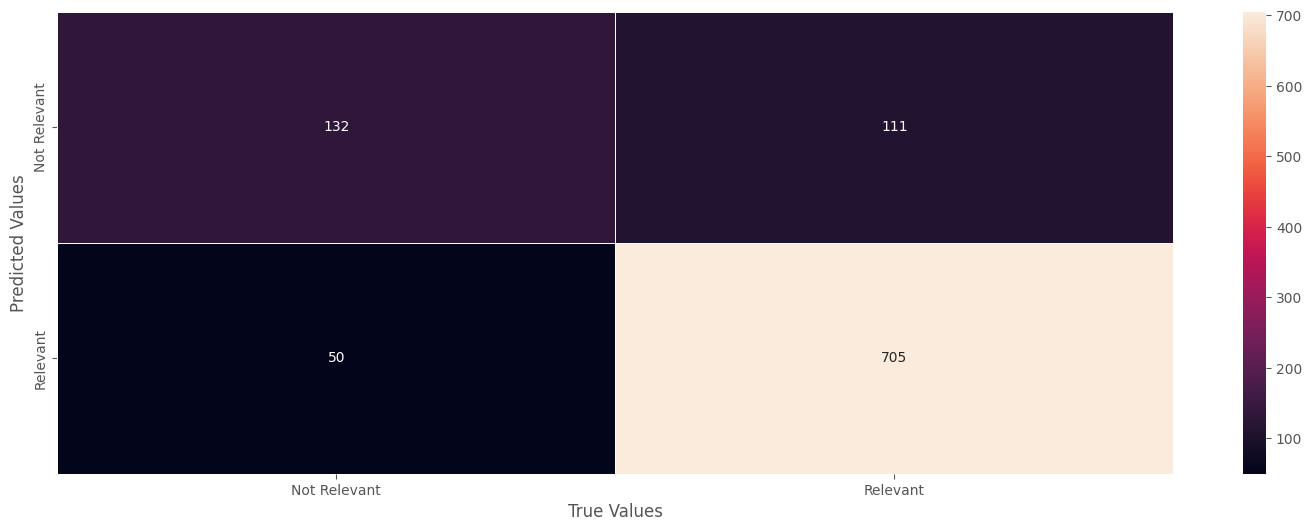

In [ ]:
p = save_history(history = history, path = "./training_info", name="bert_base_uncased")
c = save_cm(path = "./training_info", cm = cm, name='bert_base_uncased')
plot_cm(cm, normalize_cm = False)

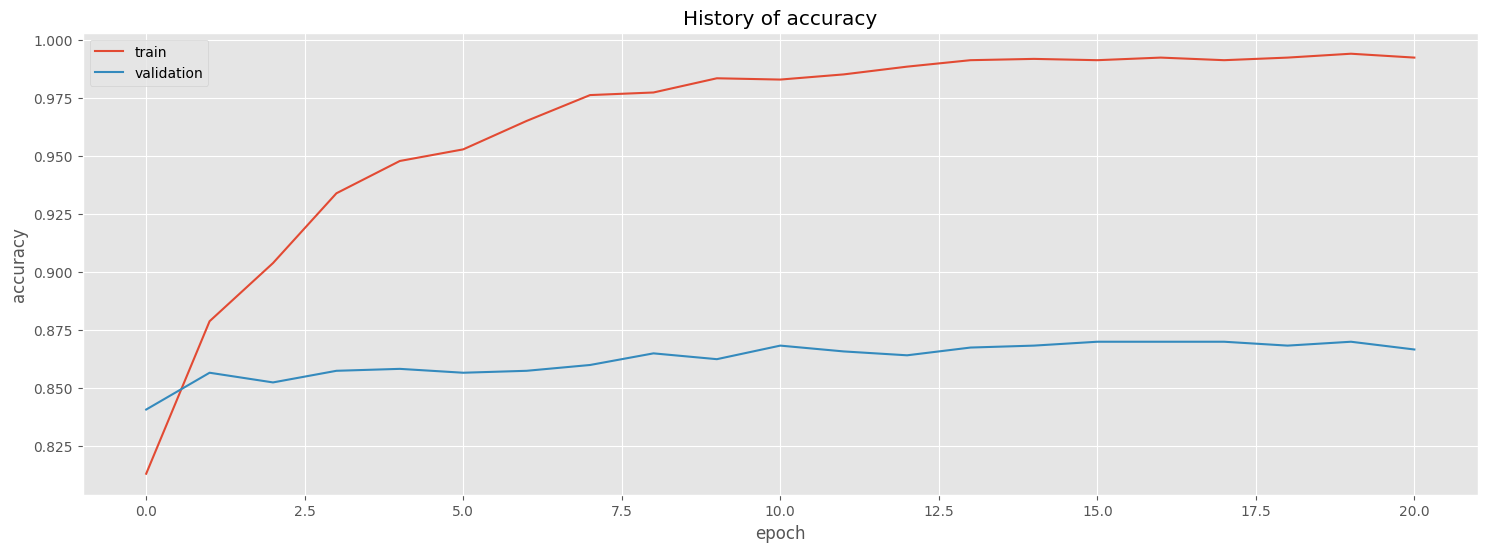

In [ ]:
learner.plot('accuracy')

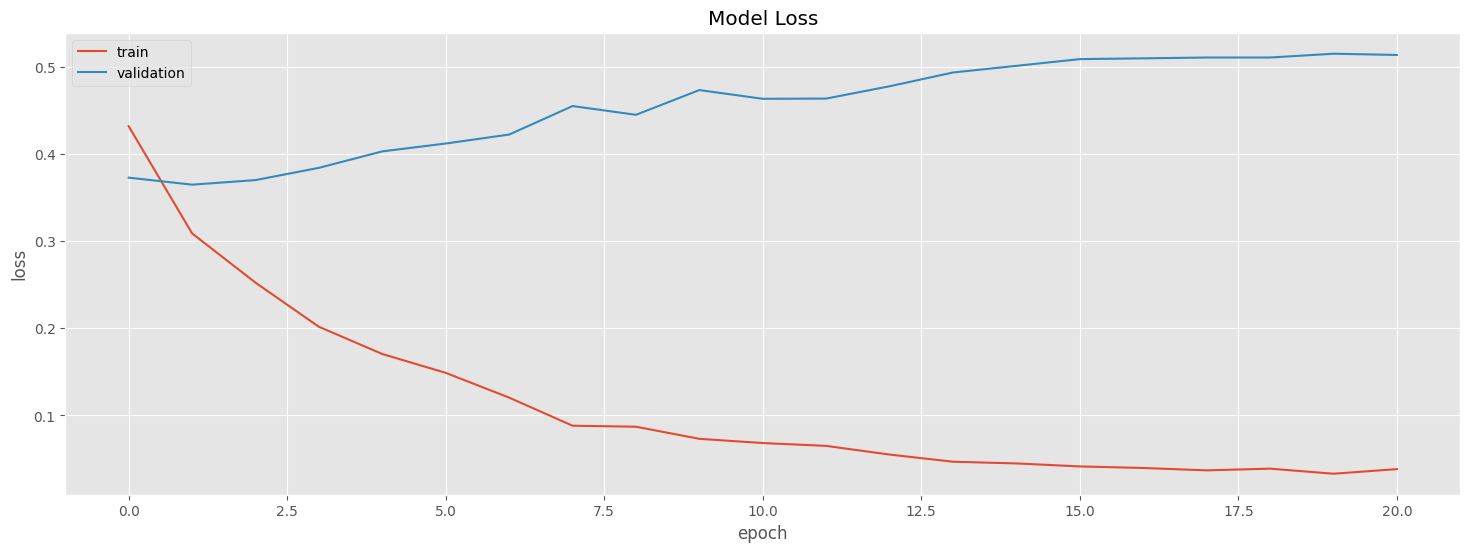

In [ ]:
learner.plot('loss')

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
predictor.predict('I like trains and disasters')

'Not Relevant'

## Bert twitter

1.   Load the model (this time we'll try DistilBERT, which is a smaller transformer model)

In [ ]:
MODEL_NAME = 'aellxx/raw_disaster_tweets'
transformer = text.Transformer(MODEL_NAME, maxlen=MAX_LEN, classes=['Not Relevant','Relevant'])

2. Process the training/test data

In [ ]:
processed_train = transformer.preprocess_train(X_train, y_train)
processed_val = transformer.preprocess_test(X_val, y_val)
processed_test = transformer.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 11
	95percentile : 18
	99percentile : 20


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 17
	99percentile : 20


preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 17
	99percentile : 20


3. Create a model and learner

In [ ]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)

In [ ]:
display(model.summary())

Model: "tf_roberta_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


None

Next, we call the lr_find and lr_plot methods to help identify a good learning rate.

In [ ]:
learner.lr_find(max_epochs=15)

simulating training for different learning rates... this may take a few moments...
Epoch 1/15
224/224 [==============================] - 77s 164ms/step - loss: 0.4308 - accuracy: 0.8192
Epoch 2/15
224/224 [==============================] - 32s 141ms/step - loss: 0.3772 - accuracy: 0.8434
Epoch 3/15
224/224 [==============================] - 34s 152ms/step - loss: 0.3266 - accuracy: 0.8658
Epoch 4/15
224/224 [==============================] - 32s 144ms/step - loss: 0.2989 - accuracy: 0.8770
Epoch 5/15
224/224 [==============================] - 32s 141ms/step - loss: 0.2689 - accuracy: 0.8909
Epoch 6/15
224/224 [==============================] - 35s 155ms/step - loss: 0.3893 - accuracy: 0.8451
Epoch 7/15
224/224 [==============================] - 31s 137ms/step - loss: 0.5576 - accuracy: 0.7567
Epoch 8/15
224/224 [==============================] - 31s 139ms/step - loss: 0.5796 - accuracy: 0.7545
Epoch 9/15
224/224 [==============================] - 31s 140ms/step - loss: 0.8448 - accurac

Invoke the larner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.

Failed to compute the gradients, there might not be enough points.
Plot displayed without suggestion.


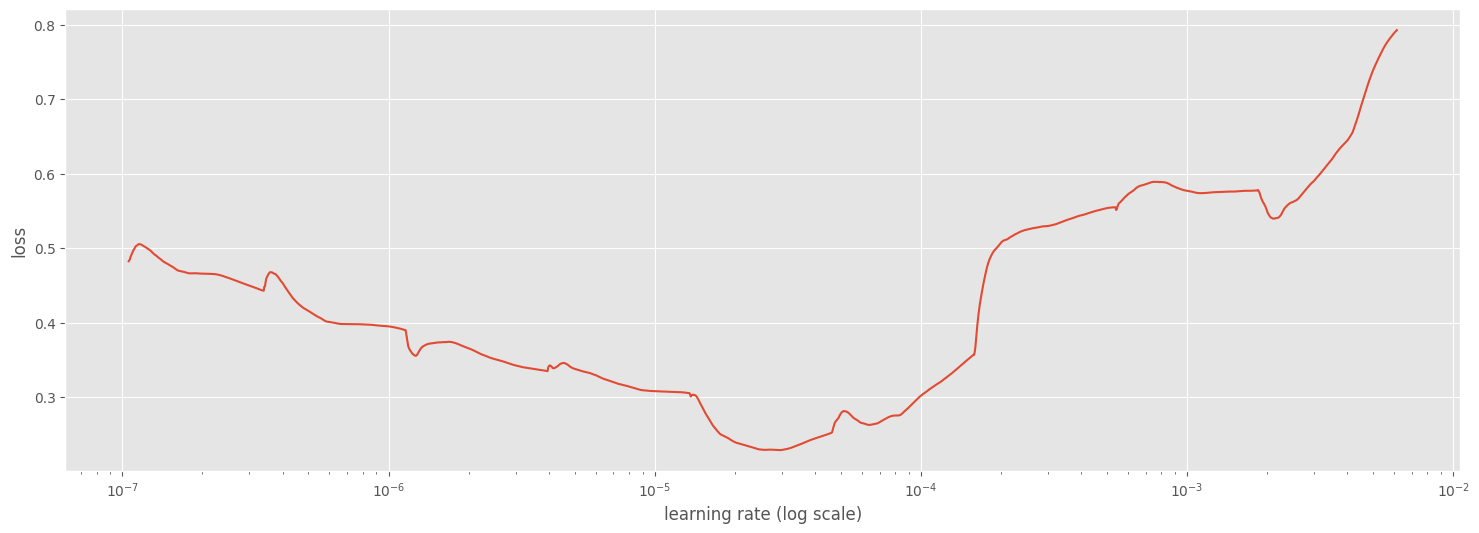

In [ ]:
learner.lr_plot(suggest=True)

In [ ]:
history = learner.autofit(2.73E-06, checkpoint_folder='./weights/twitter-bert/', monitor = 'val_accuracy')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2.73e-06...
Epoch 1/1024
225/225 [==============================] - 95s 329ms/step - loss: 0.3792 - accuracy: 0.8419 - val_loss: 0.3395 - val_accuracy: 0.8639
Epoch 2/1024
225/225 [==============================] - 62s 274ms/step - loss: 0.2890 - accuracy: 0.8808 - val_loss: 0.3468 - val_accuracy: 0.8631
Epoch 3/1024
225/225 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.8970
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 1.365e-06 (if not early_stopping).
225/225 [==============================] - 67s 300ms/step - loss: 0.2577 - accuracy: 0.8970 - val_loss: 0.3336 - val_accuracy: 0.8606
Epoch 4/1024
225/225 [==============================] - 70s 313ms/step - loss: 0.2257 - accuracy: 0.9115 - val_loss: 0.3440 - val_accuracy: 0.8598
Epoch 5/1024
225/225 [=======================

In [ ]:
cm = learner.validate(val_data = processed_test, print_report = False, class_names=transformer.get_classes(), save_path= "./training_info/bert_twitter_report.csv")

998/998 [==============================] - 52s 47ms/step
classification report saved to: ./training_info/bert_twitter_report.csv


In [ ]:
model_report = pd.read_csv("./training_info/bert_twitter_report.csv")
model_report

Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.820000  0.506173  0.625954  243.000000
1      Relevant   0.858491  0.964238  0.908297  755.000000
2      accuracy   0.852705  0.852705  0.852705    0.852705
3     macro avg   0.839245  0.735206  0.767126  998.000000
4  weighted avg   0.849119  0.852705  0.839550  998.000000

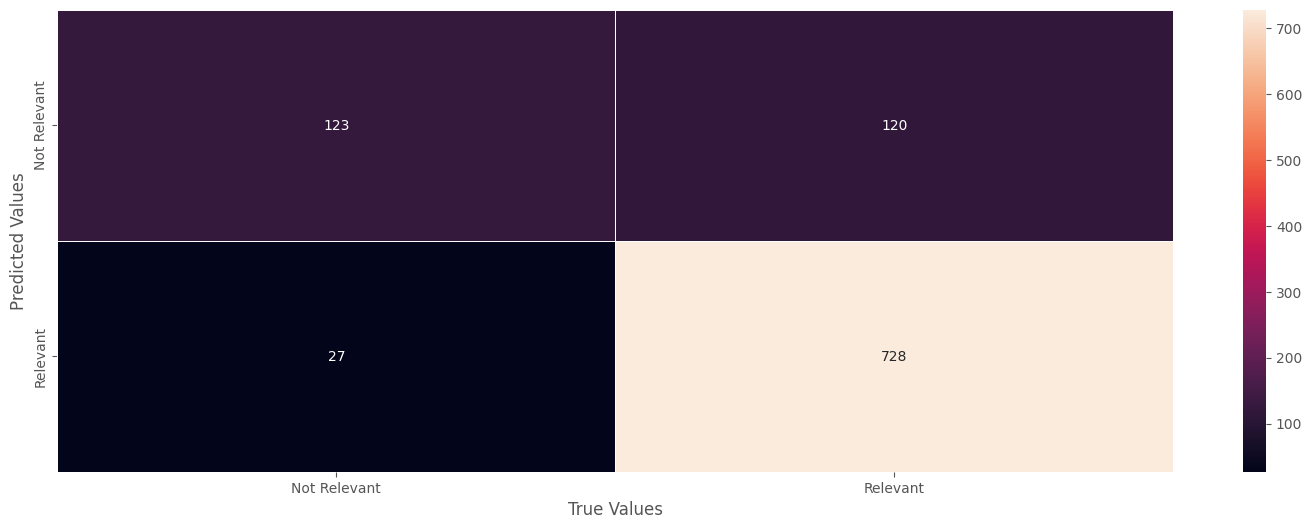

In [ ]:
p = save_history(history = history, path = "./training_info", name="bert_twitter")
c = save_cm(path = "./training_info", cm = cm, name='bert_twitter')
plot_cm(cm, normalize_cm = False)

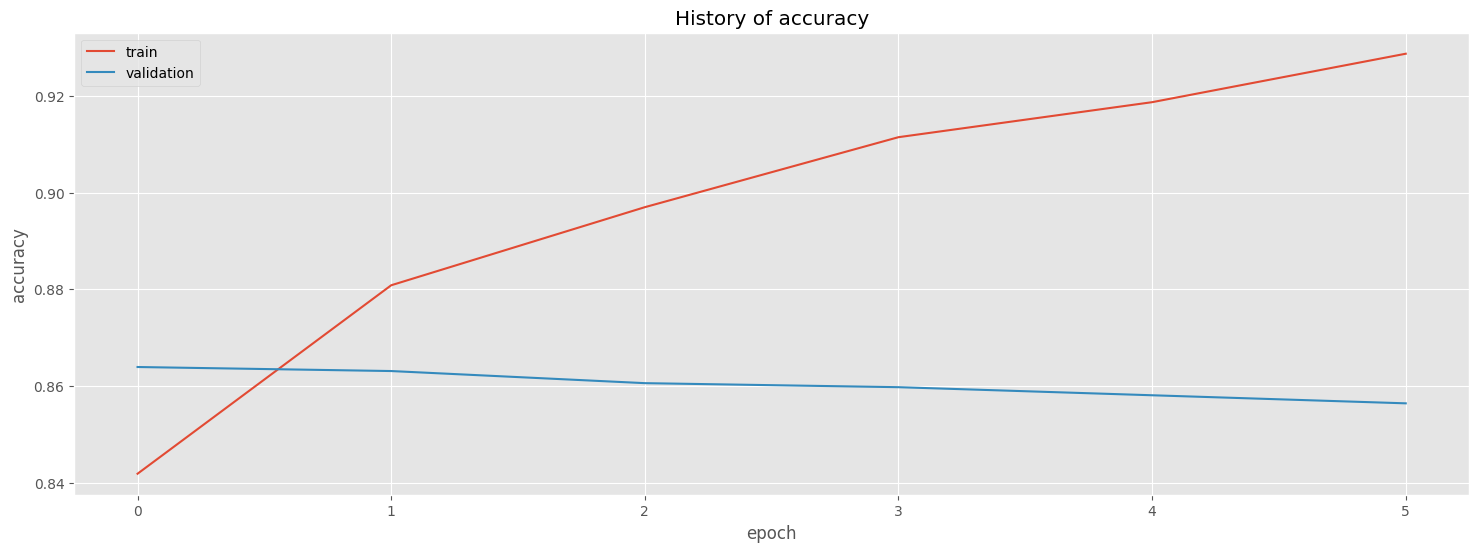

In [ ]:
learner.plot('accuracy')

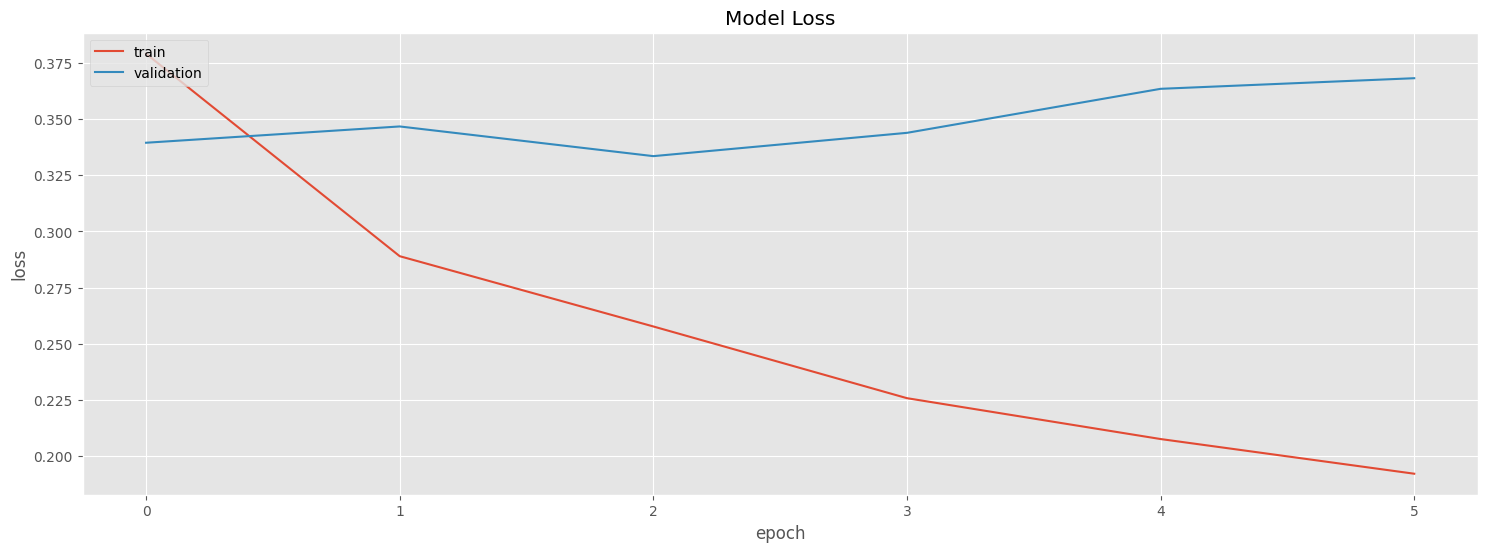

In [ ]:
learner.plot('loss')

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
predictor.predict('I like harvey disaster')

'Not Relevant'

# Trainings with CrisisMMD+


In [ ]:
MAX_LEN = 80

## Baseline GloVe model



In [ ]:
random_state_split = seed
learning_rate = 5e-4

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

epochs_num = 30
batch_size_num = 16

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['Ext Text Clean Glove']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

In [ ]:
corpus_clean=create_corpus_new(tweets_df_clean)

  0%|          | 0/3992 [00:00<?, ?it/s]

In [ ]:
if show_infos:
  print(corpus_clean)
  print(len(corpus_clean))

[['ajwamood', 'harvey', 'first', 'major', 'hurricane', 'strike', 'us', 'since', '2005', 'causes', 'least', '1', 'fatality', 'images', 'attached', 'tweet', 'depict', 'damage', 'church', 'home', 'damaged', 'hurricane', 'damaged', 'escalator', 'walmart', 'houston', 'texas', 'friday', 'jan', 'damage', 'storm'], ['always', 'good', 'city', 'shows', 'severe', 'weather', 'map', 'hurricaneharvey', 'itaintoveryet', 'image', 'attached', 'tweet', 'depicts', 'weather', 'map', 'screen', 'television'], ['side', 'side', 'satellite', 'images', 'compare', 'size', 'hurricane', 'harvey', 'hurricane', 'katrina', '2005', 'image', 'attached', 'tweet', 'depicts', 'hurricane', 'middle', 'ocean'], ['street', 'se', 'houston', 'river', 'light', 'lightning', '10pm', 'harvey', 'image', 'attached', 'tweet', 'depicts', 'flooded', 'street', 'neighborhood'], ['texas', 'countys', 'long', 'recovery', 'hurricane', 'harvey', 'begins', 'image', 'attached', 'tweet', 'depicts', 'boat', 'destroyed', 'hurricane', 'sandy'], ['sh

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
embedding_dict={}
with open('./data/glove.twitter.27B.200d.txt','r') as f:
    for idx, line in tqdm(enumerate(f)):
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

embedding_dim = 200

0it [00:00, ?it/s]

In [ ]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus_clean)
sequences=tokenizer_obj.texts_to_sequences(corpus_clean)
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 9278


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,embedding_dim))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec

  0%|          | 0/9278 [00:00<?, ?it/s]

In [ ]:
learning_rate = 1e-4

In [ ]:
model=Sequential()

embedding=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=tf.keras.optimizers.experimental.AdamW(learning_rate=learning_rate, jit_compile=False)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 80, 200)           1855800   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 80, 200)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 256)               467968    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,324,025
Trainable params: 468,225
Non-trainable params: 1,855,800
_________________________________________________________________


In [ ]:
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(
    tweet_pad,
    tweets_df_clean['text_info'].values,
    test_size=1 - train_ratio, shuffle=True, random_state = seed, stratify=tweets_df_clean['text_info'].values)

In [ ]:
X_train_pad, X_val_pad, y_train_pad, y_val_pad = train_test_split(
    X_train_pad, y_train_pad, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=True, random_state = seed, stratify=y_train_pad)

In [ ]:
es = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Recomended 10-20 epochs
history=model.fit(X_train_pad,y_train_pad,batch_size=128,epochs=epochs_num,validation_data=(X_val_pad,y_val_pad), callbacks = [es])

Epoch 1/30
15/15 [==============================] - 12s 359ms/step - loss: 0.6889 - accuracy: 0.7572 - val_loss: 0.6814 - val_accuracy: 0.7571
Epoch 2/30
15/15 [==============================] - 8s 543ms/step - loss: 0.6660 - accuracy: 0.7572 - val_loss: 0.6176 - val_accuracy: 0.7571
Epoch 3/30
15/15 [==============================] - 6s 379ms/step - loss: 0.5522 - accuracy: 0.7572 - val_loss: 0.5327 - val_accuracy: 0.7571
Epoch 4/30
15/15 [==============================] - 5s 340ms/step - loss: 0.5001 - accuracy: 0.7684 - val_loss: 0.4569 - val_accuracy: 0.7846
Epoch 5/30
15/15 [==============================] - 9s 601ms/step - loss: 0.4462 - accuracy: 0.7979 - val_loss: 0.4182 - val_accuracy: 0.8155
Epoch 6/30
15/15 [==============================] - 5s 344ms/step - loss: 0.4062 - accuracy: 0.8202 - val_loss: 0.4231 - val_accuracy: 0.8005
Epoch 7/30
15/15 [==============================] - 5s 361ms/step - loss: 0.3803 - accuracy: 0.8280 - val_loss: 0.4102 - val_accuracy: 0.8264
Epoch

In [ ]:
preds = model.predict(X_test_pad)
preds = (preds > 0.5).astype(int)
cm = confusion_matrix(preds, y_test_pad)

32/32 [==============================] - 1s 25ms/step


In [ ]:
cr = classification_report(preds, y_test_pad, output_dict=True)

In [ ]:
display(cr)

{'0': {'precision': 0.6049382716049383,
  'recall': 0.75,
  'f1-score': 0.6697038724373576,
  'support': 196},
 '1': {'precision': 0.9350993377483444,
  'recall': 0.8802992518703242,
  'f1-score': 0.9068721901091844,
  'support': 802},
 'accuracy': 0.8547094188376754,
 'macro avg': {'precision': 0.7700188046766414,
  'recall': 0.815149625935162,
  'f1-score': 0.788288031273271,
  'support': 998},
 'weighted avg': {'precision': 0.8702580862813026,
  'recall': 0.8547094188376754,
  'f1-score': 0.8602940435523928,
  'support': 998}}

In [ ]:
with open("./training_info/glove_plus_report.json", 'w') as file_pi:
  json.dump(cr, file_pi, cls=NumpyFloatValuesEncoder)

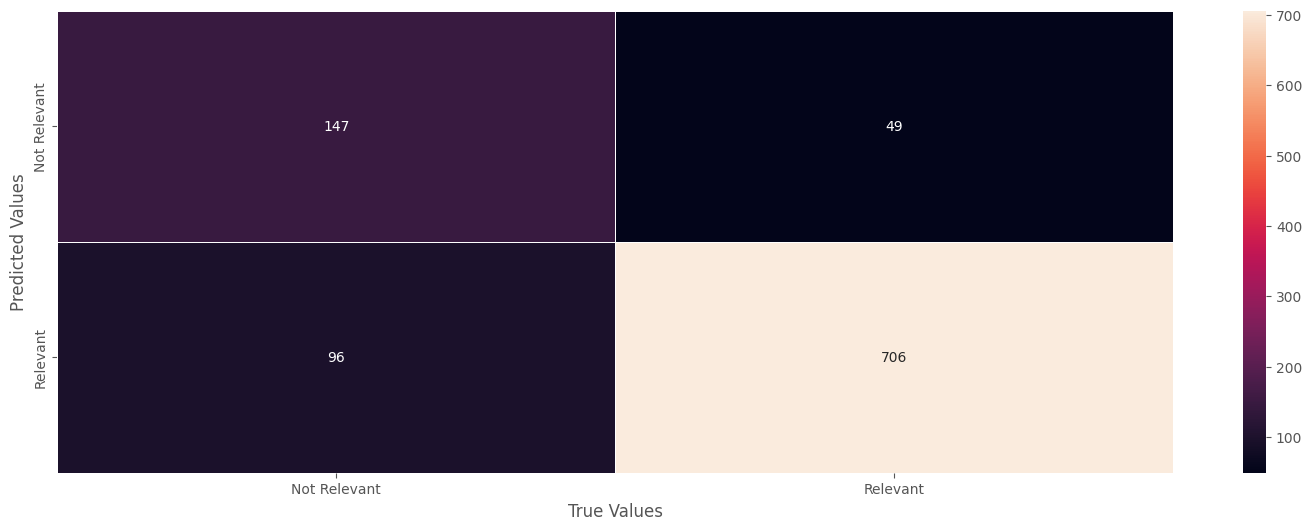

In [ ]:
p = save_history(history = history, path = "./training_info", name="glove_plus")
c = save_cm(path = "./training_info", cm = cm, name='glove_plus')
plot_cm(cm, normalize_cm = False)


## Bert data preparation

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(tweets_df_clean['Ext Text Clean Bert'].values,
                                               tweets_df_clean['text_info'].values,
                                               test_size=1-train_ratio,
                                               shuffle=True,
                                               random_state = seed,
                                               stratify =                                                tweets_df_clean['text_info'].values)

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,
                                             test_size=test_ratio/(test_ratio + validation_ratio),
                                             shuffle=True, random_state = seed,
                                             stratify=y_train)

## Bert base uncased

In [ ]:
MODEL_NAME = 'bert-base-uncased'
transformer = text.Transformer('bert-base-uncased' , maxlen=MAX_LEN, classes=['Not Relevant','Relevant'])

2. Process the training/test data

In [ ]:
processed_train = transformer.preprocess_train(X_train, y_train)
processed_val = transformer.preprocess_test(X_val, y_val)
processed_test = transformer.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 26
	95percentile : 38
	99percentile : 53


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 36
	99percentile : 51


preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 37
	99percentile : 51


3. Create a model and learner

In [ ]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)

In [ ]:
display(model.summary())

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


None

Next, we call the lr_find and lr_plot methods to help identify a good learning rate.

In [ ]:
learner.lr_find(max_epochs=15)

simulating training for different learning rates... this may take a few moments...
Epoch 1/15
224/224 [==============================] - 67s 180ms/step - loss: 0.6156 - accuracy: 0.7383
Epoch 2/15
224/224 [==============================] - 39s 176ms/step - loss: 0.5497 - accuracy: 0.7567
Epoch 3/15
224/224 [==============================] - 38s 170ms/step - loss: 0.4789 - accuracy: 0.7701
Epoch 4/15
224/224 [==============================] - 36s 160ms/step - loss: 0.3630 - accuracy: 0.8451
Epoch 5/15
224/224 [==============================] - 41s 183ms/step - loss: 0.3210 - accuracy: 0.8635
Epoch 6/15
224/224 [==============================] - 46s 205ms/step - loss: 0.3401 - accuracy: 0.8669
Epoch 7/15
224/224 [==============================] - 40s 178ms/step - loss: 0.4768 - accuracy: 0.8065
Epoch 8/15
224/224 [==============================] - 36s 163ms/step - loss: 0.6122 - accuracy: 0.7343
Epoch 9/15
224/224 [==============================] - 44s 198ms/step - loss: 0.8808 - accurac

Invoke the larner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.

Three possible suggestions for LR from plot:
	Longest valley (red): 4.98E-06
	Min numerical gradient (purple): 3.49E-06
	Min loss divided by 10 (omitted from plot): 7.20E-06


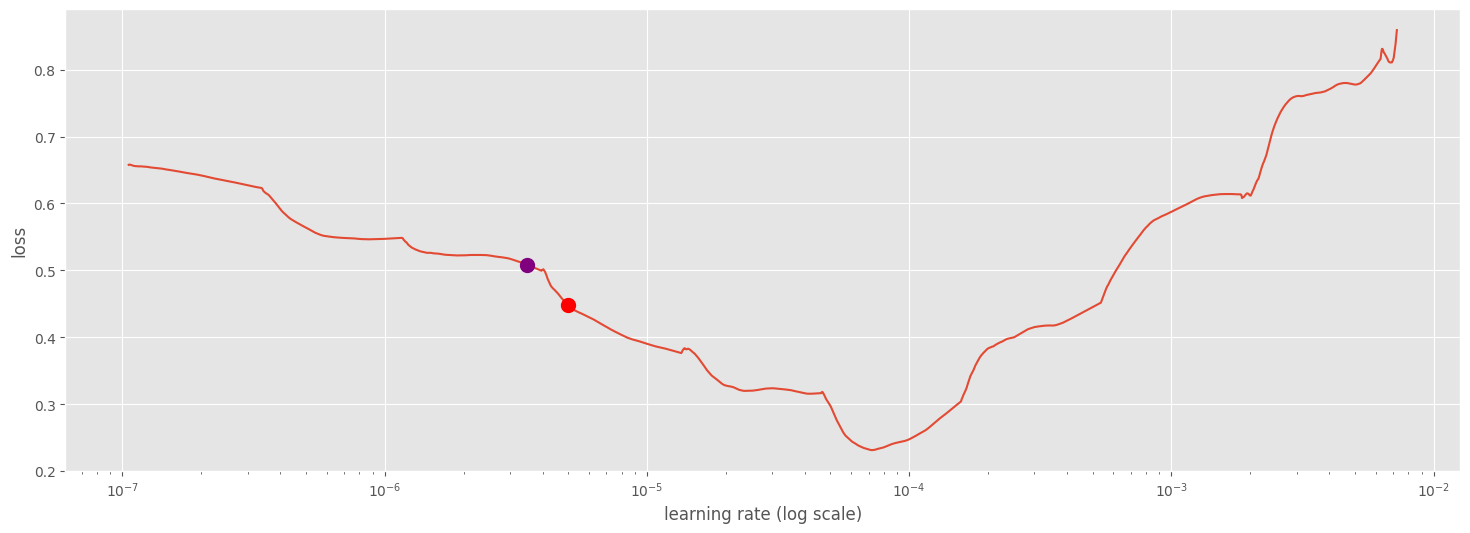

In [ ]:
learner.lr_plot(suggest=True)

In [ ]:
history = learner.autofit(7.20E-06, checkpoint_folder='./weights/bert_plus')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 7.2e-06...
Epoch 1/1024
225/225 [==============================] - 91s 303ms/step - loss: 0.4578 - accuracy: 0.8073 - val_loss: 0.3655 - val_accuracy: 0.8598
Epoch 2/1024
225/225 [==============================] - 65s 288ms/step - loss: 0.3060 - accuracy: 0.8753 - val_loss: 0.3696 - val_accuracy: 0.8656
Epoch 3/1024
225/225 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9165
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 3.6e-06 (if not early_stopping).
225/225 [==============================] - 58s 260ms/step - loss: 0.2255 - accuracy: 0.9165 - val_loss: 0.3679 - val_accuracy: 0.8523
Epoch 4/1024
225/225 [==============================] - 73s 323ms/step - loss: 0.1637 - accuracy: 0.9427 - val_loss: 0.3915 - val_accuracy: 0.8581
Epoch 5/1024
225/225 [==========================

In [ ]:
cm = learner.validate(val_data = processed_test, print_report = False, class_names=transformer.get_classes(), save_path= "./training_info/bert_plus_report.csv")

998/998 [==============================] - 44s 41ms/step
classification report saved to: ./training_info/bert_plus_report.csv


In [ ]:
model_report = pd.read_csv("./training_info/bert_plus_report.csv")
model_report

Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.784946  0.600823  0.680653  243.000000
1      Relevant   0.880542  0.947020  0.912572  755.000000
2      accuracy   0.862725  0.862725  0.862725    0.862725
3     macro avg   0.832744  0.773921  0.796612  998.000000
4  weighted avg   0.857266  0.862725  0.856103  998.000000

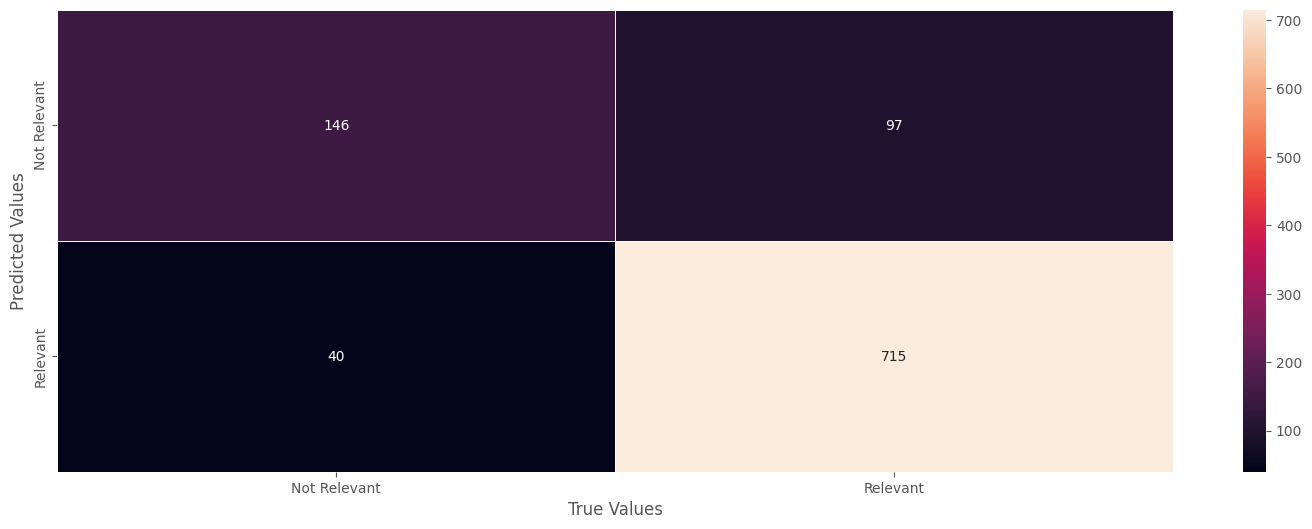

In [ ]:
p = save_history(history = history, path = "./training_info", name="bert_plus")
c = save_cm(path = "./training_info", cm = cm, name='bert_plus')
plot_cm(cm, normalize_cm = False)

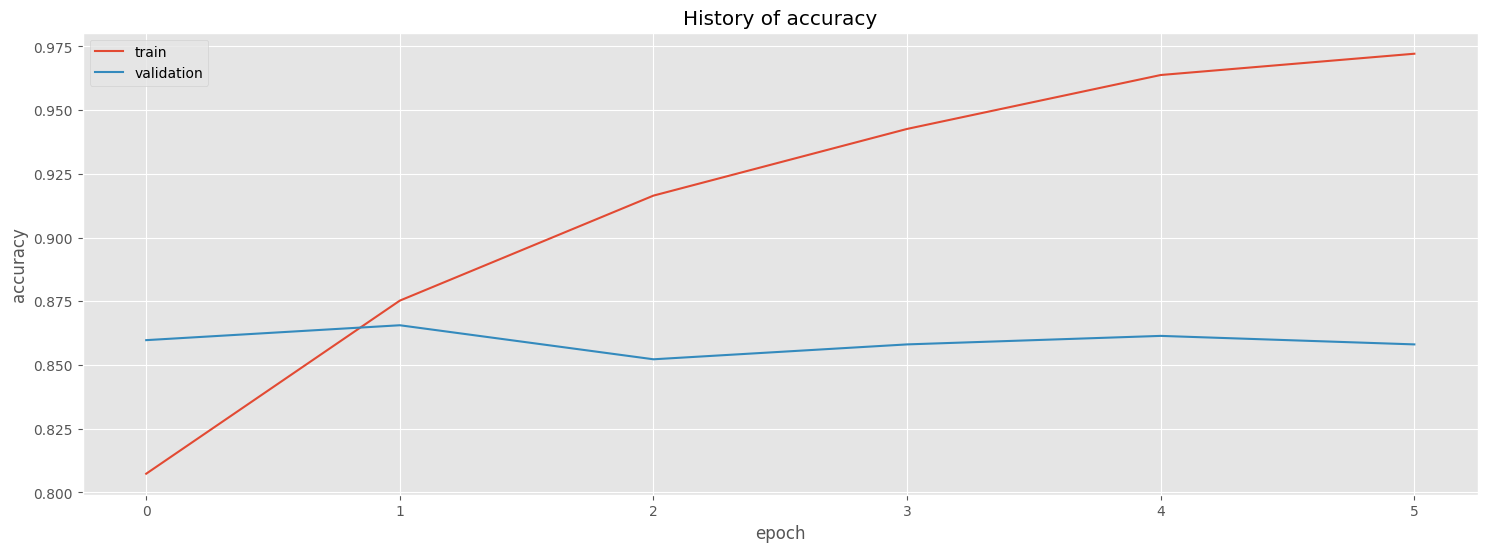

In [ ]:
learner.plot('accuracy')

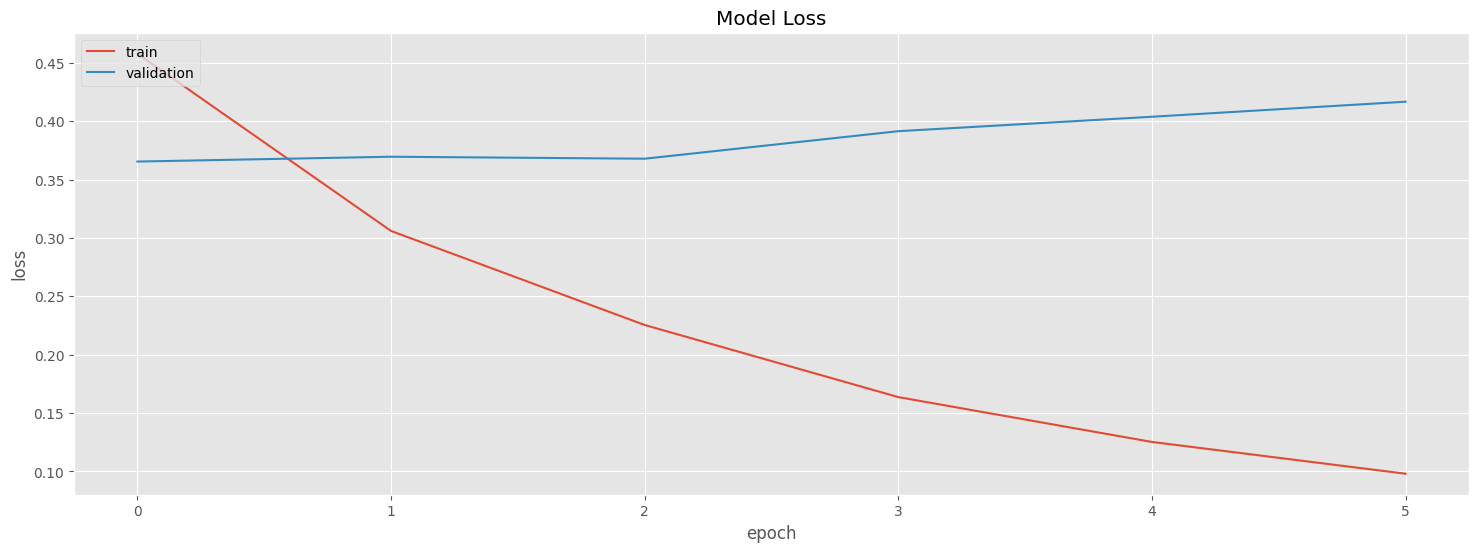

In [ ]:
learner.plot('loss')

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
predictor.predict('I like trains and disasters but not')

'Not Relevant'

## Bert twitter

In [ ]:
MODEL_NAME = 'aellxx/raw_disaster_tweets'
transformer = text.Transformer(MODEL_NAME, maxlen=MAX_LEN, classes=['Not Relevant','Relevant'])

2. Process the training/test data

In [ ]:
processed_train = transformer.preprocess_train(X_train, y_train)
processed_val = transformer.preprocess_test(X_val, y_val)
processed_test = transformer.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 26
	95percentile : 38
	99percentile : 53


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 36
	99percentile : 51


preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 37
	99percentile : 51


3. Create a model and learner

In [ ]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)

In [ ]:
display(model.summary())

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


None

Next, we call the lr_find and lr_plot methods to help identify a good learning rate.

In [ ]:
learner.lr_find(max_epochs=15)

simulating training for different learning rates... this may take a few moments...
Epoch 1/15
224/224 [==============================] - 59s 169ms/step - loss: 0.4431 - accuracy: 0.8058
Epoch 2/15
224/224 [==============================] - 41s 184ms/step - loss: 0.3868 - accuracy: 0.8322
Epoch 3/15
224/224 [==============================] - 42s 187ms/step - loss: 0.3350 - accuracy: 0.8591
Epoch 4/15
224/224 [==============================] - 39s 173ms/step - loss: 0.2889 - accuracy: 0.8781
Epoch 5/15
224/224 [==============================] - 43s 193ms/step - loss: 0.2715 - accuracy: 0.8876
Epoch 6/15
224/224 [==============================] - 40s 181ms/step - loss: 0.3914 - accuracy: 0.8496
Epoch 7/15
224/224 [==============================] - 46s 205ms/step - loss: 0.5668 - accuracy: 0.7589
Epoch 8/15
224/224 [==============================] - 43s 193ms/step - loss: 0.6004 - accuracy: 0.7315
Epoch 9/15
224/224 [==============================] - 38s 168ms/step - loss: 0.6618 - accurac

Invoke the larner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.

Three possible suggestions for LR from plot:
	Longest valley (red): 1.00E-05
	Min numerical gradient (purple): 3.34E-06
	Min loss divided by 10 (omitted from plot): 6.67E-06


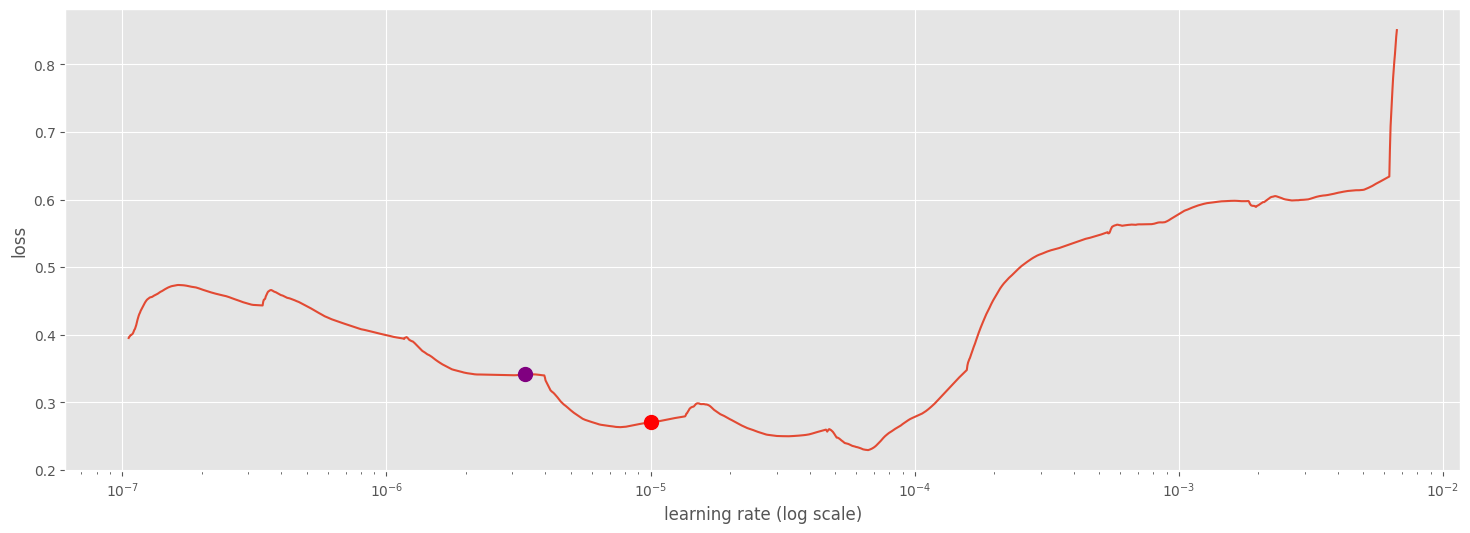

In [ ]:
learner.lr_plot(suggest=True)

In [ ]:
history = learner.autofit(6.67E-06, checkpoint_folder='./weights/twitter-bert-plus/', monitor="val_accuracy")

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 6.67e-06...
Epoch 1/1024
225/225 [==============================] - 127s 416ms/step - loss: 0.3817 - accuracy: 0.8369 - val_loss: 0.3547 - val_accuracy: 0.8414
Epoch 2/1024
225/225 [==============================] - 83s 370ms/step - loss: 0.2612 - accuracy: 0.8959 - val_loss: 0.3598 - val_accuracy: 0.8539
Epoch 3/1024
225/225 [==============================] - 83s 369ms/step - loss: 0.1910 - accuracy: 0.9337 - val_loss: 0.3809 - val_accuracy: 0.8531
Epoch 4/1024
225/225 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9599
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 3.335e-06 (if not early_stopping).
225/225 [==============================] - 79s 354ms/step - loss: 0.1248 - accuracy: 0.9599 - val_loss: 0.4353 - val_accuracy: 0.8456
Epoch 5/1024
225/225 [======================

In [ ]:
cm = learner.validate(val_data = processed_test, print_report = False, class_names=transformer.get_classes(), save_path= "./training_info/twitter_bert_plus_report.csv")

998/998 [==============================] - 46s 42ms/step
classification report saved to: ./training_info/twitter_bert_plus_report.csv


In [ ]:
model_report = pd.read_csv("./training_info/twitter_bert_plus_report.csv")
model_report

Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.812155  0.604938  0.693396  243.000000
1      Relevant   0.882497  0.954967  0.917303  755.000000
2      accuracy   0.869739  0.869739  0.869739    0.869739
3     macro avg   0.847326  0.779953  0.805350  998.000000
4  weighted avg   0.865370  0.869739  0.862784  998.000000

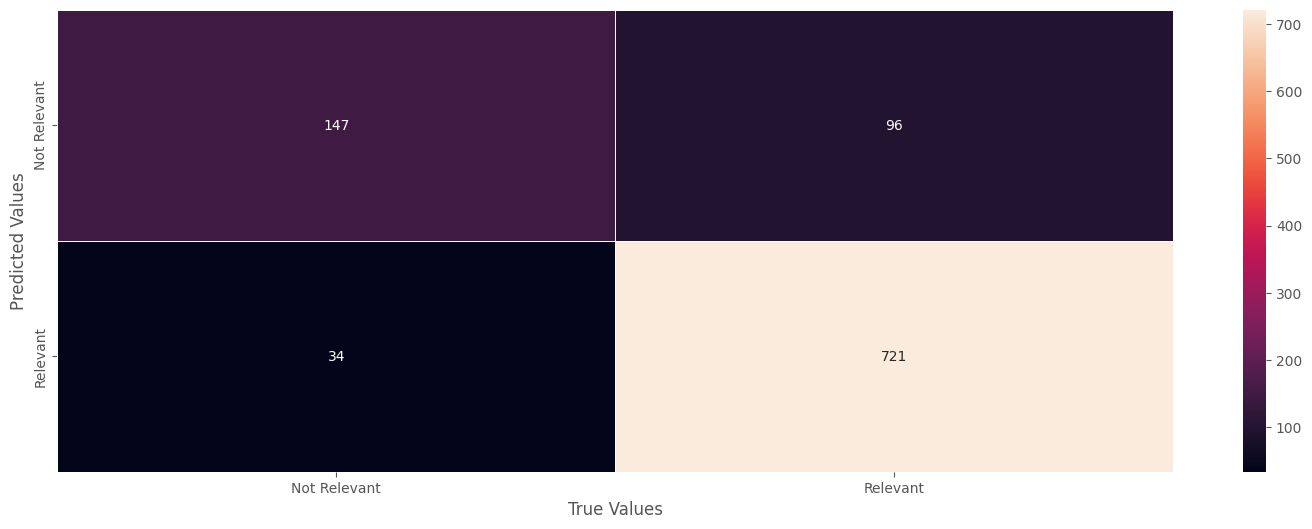

In [ ]:
p = save_history(history = history, path = "./training_info", name="bert_plus_twitter")
c = save_cm(path = "./training_info", cm = cm, name='bert_plus_twitter')
plot_cm(cm, normalize_cm = False)

In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1vU8BJNBAeSoW1YXngr3ae5nPlrOuMpYj/Multidisciplinary project


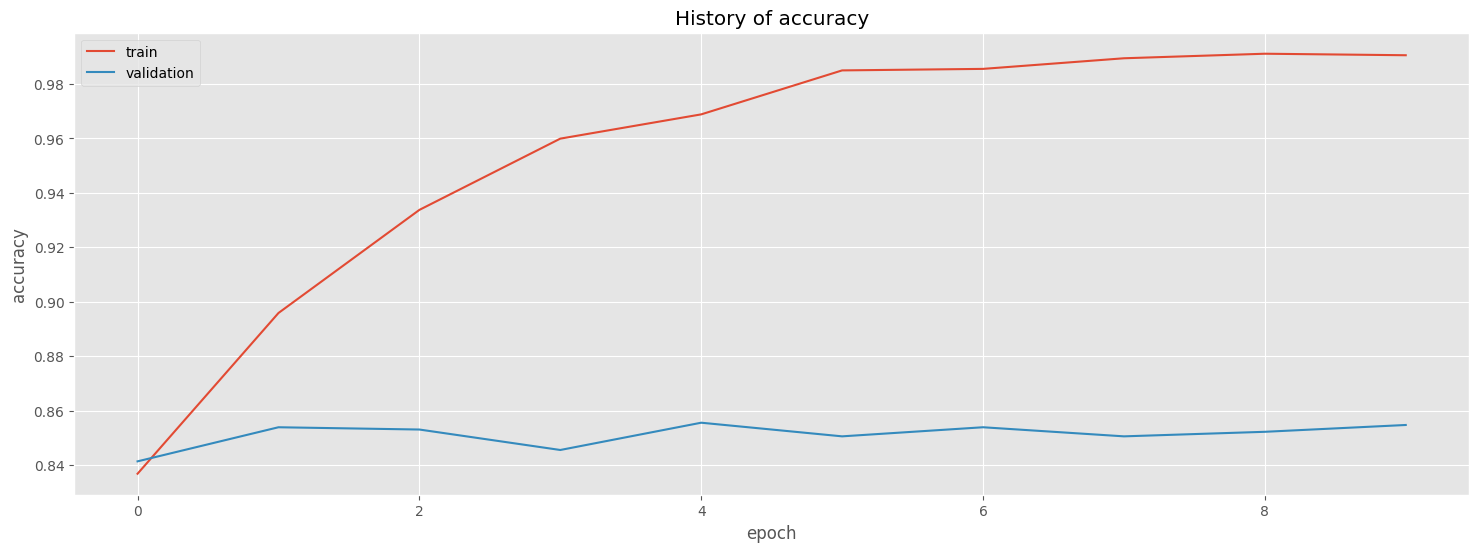

In [ ]:
learner.plot('accuracy')

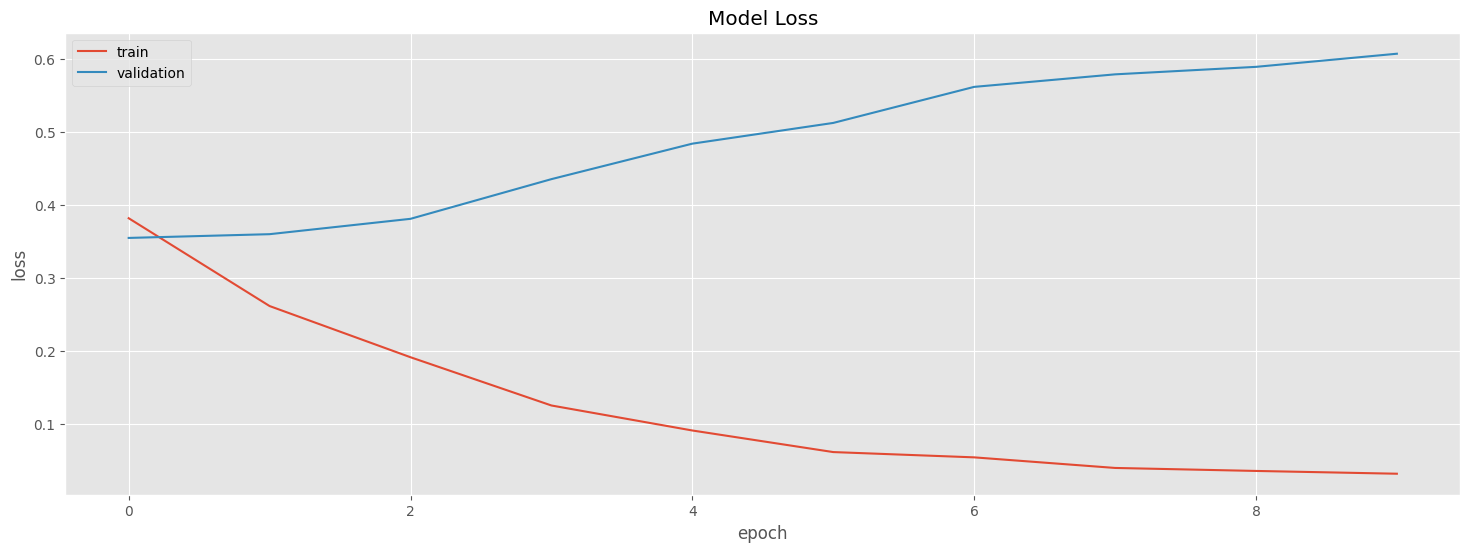

In [ ]:
learner.plot('loss')

## Bert xlm

1.   Load the model (this time we'll try DistilBERT, which is a smaller transformer model)

In [ ]:
MODEL_NAME = 'cardiffnlp/twitter-xlm-roberta-base'
transformer = text.Transformer(MODEL_NAME, maxlen=MAX_LEN, classes=['Not Relevant','Relevant'])

2. Process the training/test data

In [ ]:
processed_train = transformer.preprocess_train(X_train, y_train)
processed_val = transformer.preprocess_test(X_val, y_val)
processed_test = transformer.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 26
	95percentile : 38
	99percentile : 53


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 36
	99percentile : 51


preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 37
	99percentile : 51


3. Create a model and learner

In [ ]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)

In [ ]:
display(model.summary())

Next, we call the lr_find and lr_plot methods to help identify a good learning rate.

In [ ]:
learner.lr_find(max_epochs=15)

simulating training for different learning rates... this may take a few moments...
Epoch 1/15
224/224 [==============================] - 80s 243ms/step - loss: 0.6216 - accuracy: 0.7305
Epoch 2/15
224/224 [==============================] - 54s 242ms/step - loss: 0.4949 - accuracy: 0.7595
Epoch 3/15
224/224 [==============================] - 56s 248ms/step - loss: 0.4328 - accuracy: 0.7707
Epoch 4/15
224/224 [==============================] - 55s 244ms/step - loss: 0.3785 - accuracy: 0.8428
Epoch 5/15
224/224 [==============================] - 54s 243ms/step - loss: 0.3602 - accuracy: 0.8658
Epoch 6/15
224/224 [==============================] - 55s 247ms/step - loss: 0.4298 - accuracy: 0.8205
Epoch 7/15
224/224 [==============================] - 54s 242ms/step - loss: 0.5707 - accuracy: 0.7601
Epoch 8/15
224/224 [==============================] - 54s 241ms/step - loss: 0.5709 - accuracy: 0.7562
Epoch 9/15
224/224 [==============================] - 55s 246ms/step - loss: 0.6899 - accurac

Invoke the larner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.

Three possible suggestions for LR from plot:
	Longest valley (red): 3.53E-06
	Min numerical gradient (purple): 2.87E-07
	Min loss divided by 10 (omitted from plot): 7.28E-07


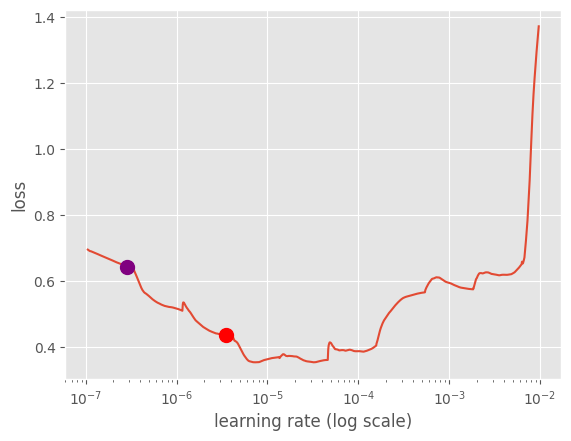

In [ ]:
learner.lr_plot(suggest=True)

In [ ]:
import gc

gc.collect()

15706

In [ ]:
history = learner.autofit(8E-06, checkpoint_folder='./weights/twitter-xlm-roberta/', monitor = 'val_accuracy')

In [ ]:
cm = learner.validate(val_data = processed_test, print_report = False, class_names=transformer.get_classes(), save_path= "./training_info/twitter-xlm-roberta_report.csv")

998/998 [==============================] - 50s 45ms/step
classification report saved to: ./training_info/twitter-xlm-roberta_report.csv


In [ ]:
model_report = pd.read_csv("./training_info/twitter-xlm-roberta_report.csv")
model_report

Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.772222  0.572016  0.657210  243.000000
1      Relevant   0.872861  0.945695  0.907819  755.000000
2      accuracy   0.854709  0.854709  0.854709    0.854709
3     macro avg   0.822541  0.758856  0.782515  998.000000
4  weighted avg   0.848356  0.854709  0.846799  998.000000

In [ ]:
model_report = pd.read_csv("./training_info/twitter-xlm-roberta_report.csv")
model_report

Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.779006  0.580247  0.665094  243.000000
1      Relevant   0.875153  0.947020  0.909669  755.000000
2      accuracy   0.857715  0.857715  0.857715    0.857715
3     macro avg   0.827079  0.763633  0.787382  998.000000
4  weighted avg   0.851742  0.857715  0.850118  998.000000

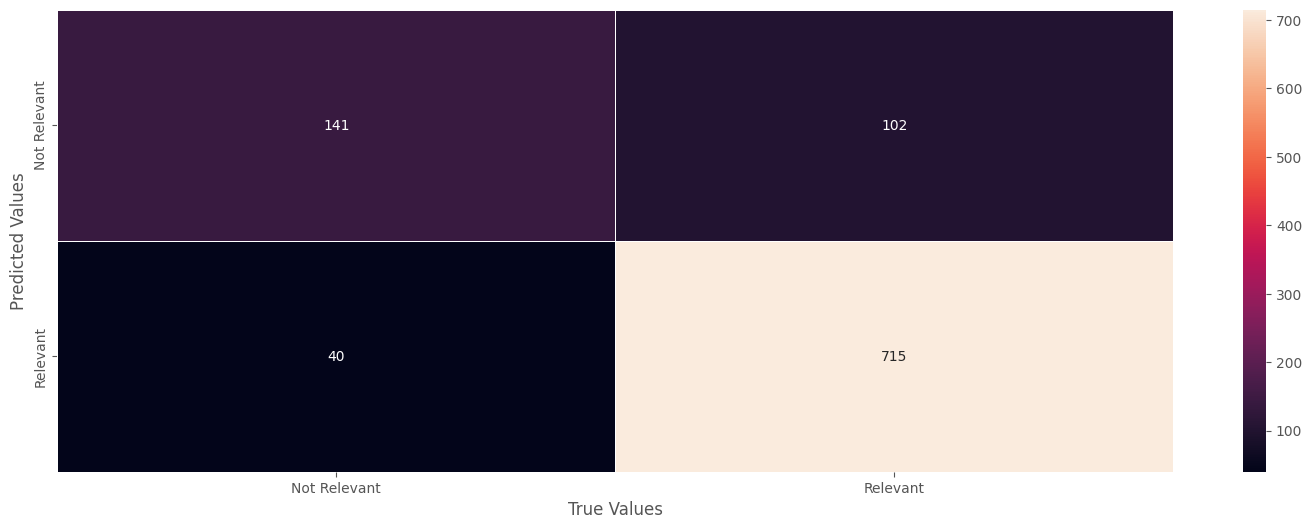

In [ ]:
p = save_history(history = history, path = "./training_info", name="twitter-xlm-roberta")
c = save_cm(path = "./training_info", cm = cm, name='twitter-xlm-roberta')
plot_cm(cm, normalize_cm = False)

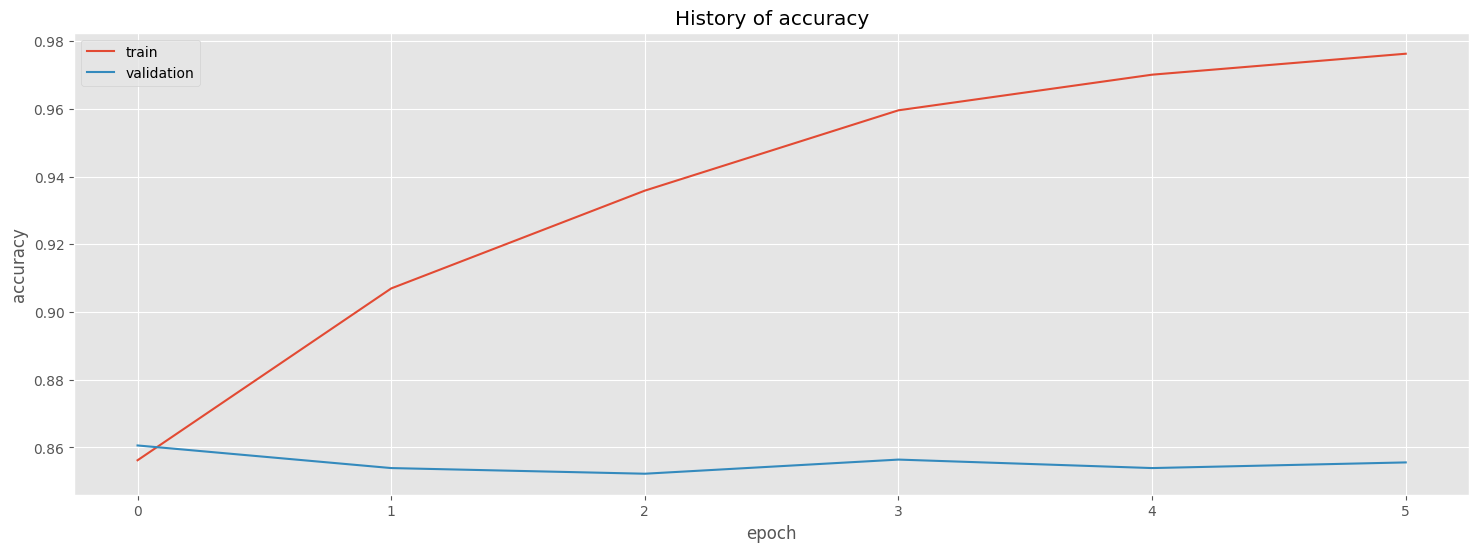

In [ ]:
learner.plot('accuracy')

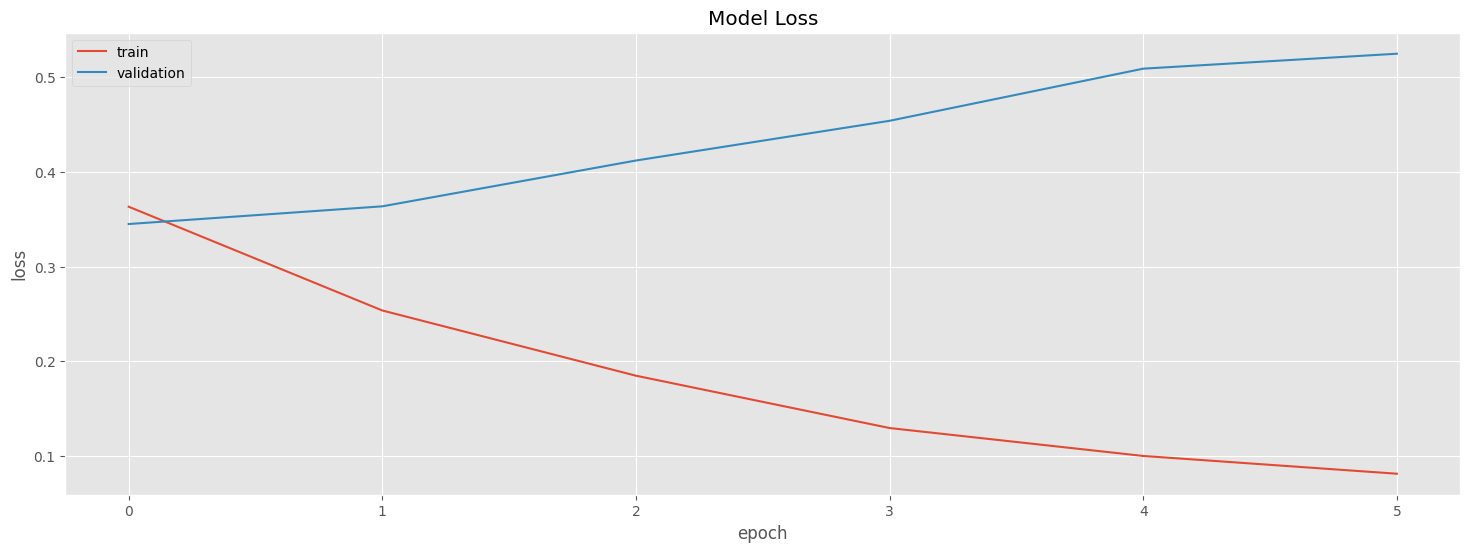

In [ ]:
learner.plot('loss')

In [ ]:
predictor.predict('I like harvey disaster')

'Not Relevant'

# Trainings with CrisisMMD+ and synthetic tweets


In [ ]:
MAX_LEN=80

In [ ]:
def build_sample_label_lists(df, model_name, add_synthetic=False):
  samples = []
  labels = []
  for idx, row in df.iterrows():
    samples.append(row[f'Ext Text Clean {model_name}'])
    labels.append(row['text_info'])

    if add_synthetic:
      if not isinstance(row[f'Ext Text S1 Clean {model_name}'], float):
        samples.append(row[f'Ext Text S1 Clean {model_name}'])
        labels.append(row['text_info'])

      if not isinstance(row[f'Ext Text S2 Clean {model_name}'], float):
        samples.append(row[f'Ext Text S2 Clean {model_name}'])
        labels.append(row['text_info'])


  c = list(zip(samples, labels))

  random.Random(42).shuffle(c)

  samples, labels = zip(*c)

  return list(samples), list(labels)

In [ ]:
samples, labels = build_sample_label_lists(tweets_df_clean, model_name='Glove', add_synthetic = True)

In [ ]:
random_state_split = seed
learning_rate = 1e-4

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

epochs_num = 30
batch_size_num = 16

## Baseline GloVe model



In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def create_corpus_new(samples):
    corpus=[]
    for tweet in tqdm(samples):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

In [ ]:
corpus_clean=create_corpus_new(samples)

  0%|          | 0/10782 [00:00<?, ?it/s]

In [ ]:
if show_infos:
  print(corpus_clean)
  print(len(corpus_clean))

[['ajwamood', 'harvey', 'first', 'major', 'hurricane', 'strike', 'us', 'since', '2005', 'causes', 'least', '1', 'fatality', 'images', 'attached', 'tweet', 'depict', 'damage', 'church', 'home', 'damaged', 'hurricane', 'damaged', 'escalator', 'walmart', 'houston', 'texas', 'friday', 'jan', 'damage', 'storm'], ['harvey', 'first', 'major', 'hurricane', 'hit', 'us', 'since', '2005', 'causing', 'least', 'one', 'fatality', 'please', 'stay', 'safe', 'take', 'precautions'], ['damage', 'caused', 'hurricane', 'harvey', 'extensive', 'need', 'come', 'together', 'support', 'affected'], ['always', 'good', 'city', 'shows', 'severe', 'weather', 'map', 'hurricaneharvey', 'itaintoveryet', 'image', 'attached', 'tweet', 'depicts', 'weather', 'map', 'screen', 'television'], ['severe', 'weather', 'map', 'shows', 'hurricane', 'harvey', 'force', 'reckoned', 'please', 'stay', 'safe', 'take', 'necessary', 'precautions'], ['attached', 'image', 'hurricane', 'harvey', 'reminder', 'power', 'nature', 'importance', 'p

### Try clean corpus

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
embedding_dict={}
with open('./data/glove.twitter.27B.200d.txt','r') as f:
    for idx, line in tqdm(enumerate(f)):
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

embedding_dim = 200

0it [00:00, ?it/s]

In [ ]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus_clean)
sequences=tokenizer_obj.texts_to_sequences(corpus_clean)
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 10782


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,embedding_dim))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec

  0%|          | 0/10782 [00:00<?, ?it/s]

In [ ]:
model=Sequential()

embedding=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=tf.keras.optimizers.experimental.AdamW(learning_rate=learning_rate, jit_compile=False)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 80, 200)           2156600   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 80, 200)          0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 256)               467968    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,624,825
Trainable params: 468,225
Non-trainable params: 2,156,600
_________________________________________________________________


In [ ]:
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(
    tweet_pad,
    labels,
    test_size=1 - train_ratio, shuffle=True, random_state = seed, stratify=labels)

In [ ]:
X_train_pad, X_val_pad, y_train_pad, y_val_pad = train_test_split(
    X_train_pad, y_train_pad, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=True, random_state = seed, stratify=y_train_pad)

In [ ]:
es = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Recomended 10-20 epochs
history=model.fit(X_train_pad,y_train_pad,batch_size=128,epochs=epochs_num,validation_data=(X_val_pad,y_val_pad), callbacks = [es])

Epoch 1/30
38/38 [==============================] - 21s 466ms/step - loss: 0.6514 - accuracy: 0.7452 - val_loss: 0.5544 - val_accuracy: 0.7580
Epoch 2/30
38/38 [==============================] - 19s 518ms/step - loss: 0.5209 - accuracy: 0.7594 - val_loss: 0.4633 - val_accuracy: 0.7734
Epoch 3/30
38/38 [==============================] - 20s 534ms/step - loss: 0.4544 - accuracy: 0.7864 - val_loss: 0.4213 - val_accuracy: 0.8250
Epoch 4/30
38/38 [==============================] - 18s 433ms/step - loss: 0.4166 - accuracy: 0.8211 - val_loss: 0.4109 - val_accuracy: 0.8306
Epoch 5/30
38/38 [==============================] - 17s 443ms/step - loss: 0.4164 - accuracy: 0.8283 - val_loss: 0.4023 - val_accuracy: 0.8340
Epoch 6/30
38/38 [==============================] - 18s 454ms/step - loss: 0.3982 - accuracy: 0.8341 - val_loss: 0.3971 - val_accuracy: 0.8414
Epoch 7/30
38/38 [==============================] - 17s 438ms/step - loss: 0.4025 - accuracy: 0.8378 - val_loss: 0.3950 - val_accuracy: 0.8414

In [ ]:
preds = model.predict(X_test_pad)
preds = (preds > 0.5).astype(int)
cm = confusion_matrix(preds, y_test_pad)

85/85 [==============================] - 6s 68ms/step


In [ ]:
cr = classification_report(preds, y_test_pad, output_dict=True)

In [ ]:
display(cr)

{'0': {'precision': 0.5015337423312883,
  'recall': 0.7482837528604119,
  'f1-score': 0.6005509641873278,
  'support': 437},
 '1': {'precision': 0.9461839530332681,
  'recall': 0.8561310314298363,
  'f1-score': 0.8989077387868929,
  'support': 2259},
 'accuracy': 0.8386498516320475,
 'macro avg': {'precision': 0.7238588476822783,
  'recall': 0.802207392145124,
  'f1-score': 0.7497293514871104,
  'support': 2696},
 'weighted avg': {'precision': 0.8741097163579102,
  'recall': 0.8386498516320475,
  'f1-score': 0.850546496019827,
  'support': 2696}}

In [ ]:
with open("./training_info/glove_report.json", 'w') as file_pi:
  json.dump(cr, file_pi, cls=NumpyFloatValuesEncoder)

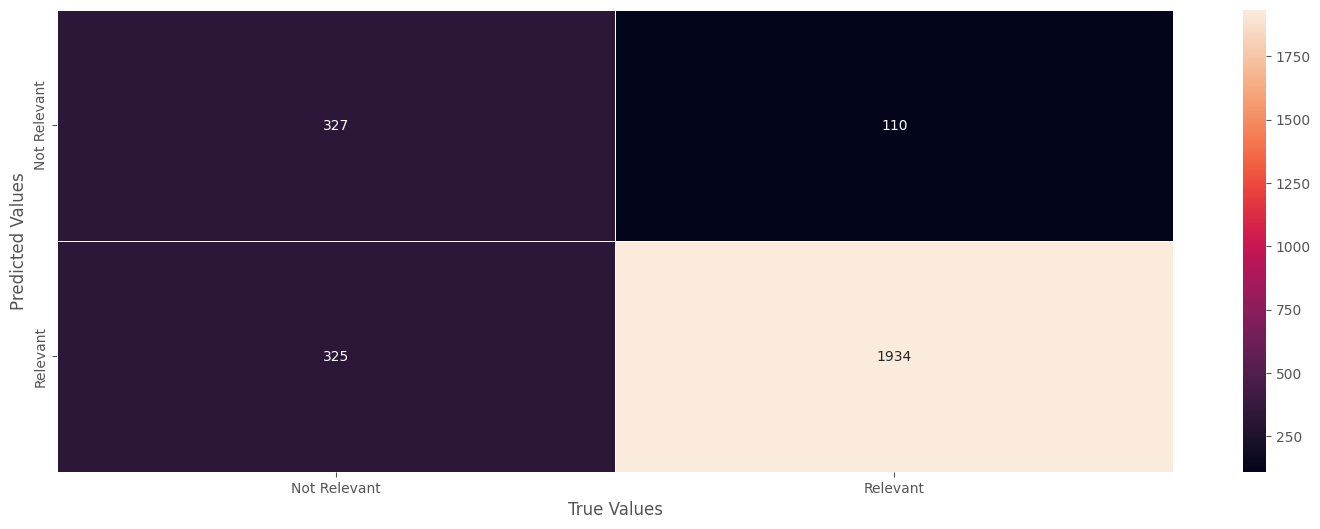

In [ ]:
p = save_history(history = history, path = "./training_info", name="glove")
c = save_cm(path = "./training_info", cm = cm, name='glove')
plot_cm(cm, normalize_cm = False)

## Bert data preparation

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(tweets_df_clean,
                                               tweets_df_clean['text_info'].values,
                                               test_size=1-train_ratio,
                                               shuffle=True,
                                               random_state = seed,
                                               stratify =                                                tweets_df_clean['text_info'].values)

NameError: ignored

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,
                                             test_size=test_ratio/(test_ratio + validation_ratio),
                                             shuffle=True, random_state = seed,
                                             stratify=y_train)

NameError: ignored

In [ ]:
X_train, y_train = build_sample_label_lists(X_train, model_name='Bert', add_synthetic = True)
#X_val, y_val = build_sample_label_lists(X_val,  model_name='Bert', add_synthetic = True)
#X_test, y_test = build_sample_label_lists(X_test,  model_name='Bert', add_synthetic = True)


In [ ]:
X_val = X_val['Ext Text Clean Bert'].values
X_test = X_test['Ext Text Clean Bert'].values

## Bert base uncased

1.   Load the model (this time we'll try DistilBERT, which is a smaller transformer model)

In [ ]:
MODEL_NAME = 'bert-base-uncased'
transformer = text.Transformer('bert-base-uncased' , maxlen=MAX_LEN, classes=['Not Relevant','Relevant'])

2. Process the training/test data

In [ ]:
processed_train = transformer.preprocess_train(X_train, y_train)
processed_val = transformer.preprocess_test(X_val, y_val)
processed_test = transformer.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 22
	95percentile : 36
	99percentile : 46


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 36
	99percentile : 51


preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 37
	99percentile : 51


3. Create a model and learner

In [ ]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)

In [ ]:
display(model.summary())

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


None

Next, we call the lr_find and lr_plot methods to help identify a good learning rate.

In [ ]:
learner.lr_find(max_epochs=15)

simulating training for different learning rates... this may take a few moments...
Epoch 1/15
606/606 [==============================] - 124s 161ms/step - loss: 0.6620 - accuracy: 0.5701
Epoch 2/15
606/606 [==============================] - 100s 164ms/step - loss: 0.5392 - accuracy: 0.7618
Epoch 3/15
606/606 [==============================] - 99s 162ms/step - loss: 0.4441 - accuracy: 0.8073
Epoch 4/15
606/606 [==============================] - 99s 163ms/step - loss: 0.3464 - accuracy: 0.8686
Epoch 5/15
606/606 [==============================] - 99s 162ms/step - loss: 0.2759 - accuracy: 0.8998
Epoch 6/15
606/606 [==============================] - 98s 162ms/step - loss: 0.2507 - accuracy: 0.9158
Epoch 7/15
606/606 [==============================] - 98s 162ms/step - loss: 0.5100 - accuracy: 0.7931
Epoch 8/15
606/606 [==============================] - 98s 161ms/step - loss: 0.5866 - accuracy: 0.7500
Epoch 9/15
606/606 [==============================] - 98s 162ms/step - loss: 0.7292 - accur

Invoke the larner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.

Three possible suggestions for LR from plot:
	Longest valley (red): 1.71E-05
	Min numerical gradient (purple): 3.22E-07
	Min loss divided by 10 (omitted from plot): 1.65E-05


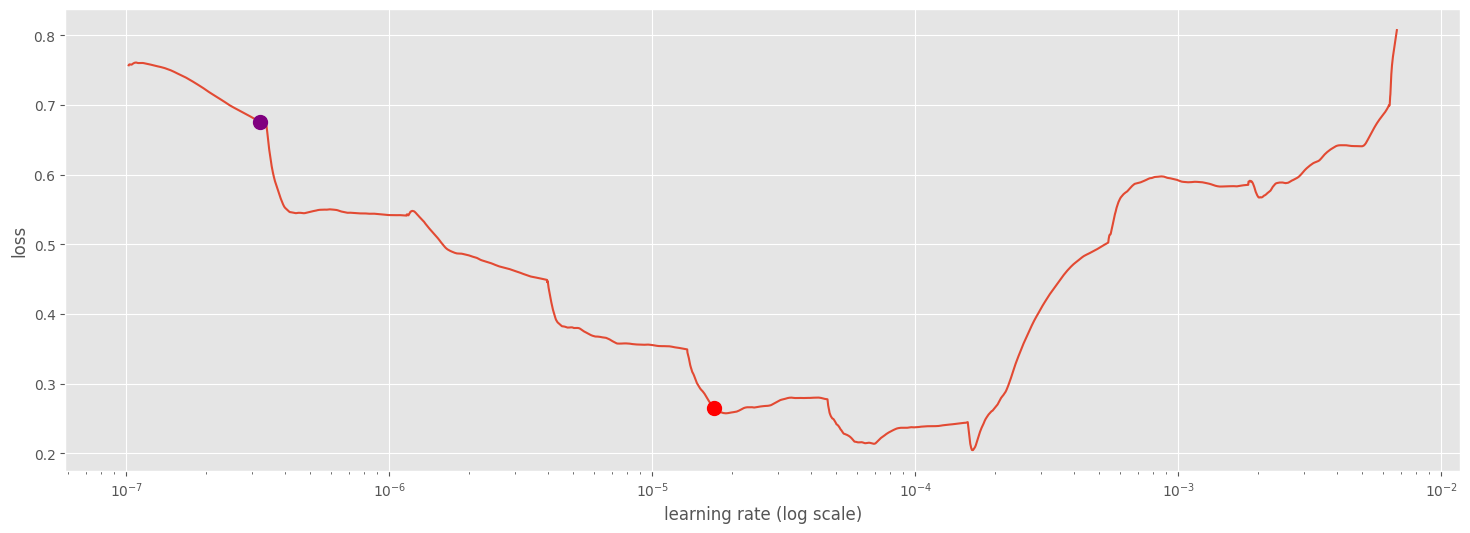

In [ ]:
learner.lr_plot(suggest=True) # batch size 64

In [ ]:
history = learner.autofit(1.65E-05, checkpoint_folder='./weights/bert-syn', monitor = 'val_accuracy')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1.65e-05...
Epoch 1/1024
606/606 [==============================] - 118s 192ms/step - loss: 0.3166 - accuracy: 0.8791 - val_loss: 0.3634 - val_accuracy: 0.8548
Epoch 2/1024
606/606 [==============================] - 120s 199ms/step - loss: 0.2090 - accuracy: 0.9288 - val_loss: 0.4091 - val_accuracy: 0.8497
Epoch 3/1024
606/606 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9569
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 8.25e-06 (if not early_stopping).
606/606 [==============================] - 125s 207ms/step - loss: 0.1345 - accuracy: 0.9569 - val_loss: 0.4730 - val_accuracy: 0.8456
Epoch 4/1024
606/606 [==============================] - 119s 196ms/step - loss: 0.0701 - accuracy: 0.9812 - val_loss: 0.5579 - val_accuracy: 0.8422
Epoch 5/1024
606/606 [====================

In [ ]:
cm = learner.validate(val_data = processed_test, print_report = False, class_names=transformer.get_classes(), save_path= "./training_info/bert_syn_report.csv")

998/998 [==============================] - 59s 54ms/step
classification report saved to: ./training_info/bert_report.csv


In [ ]:
model_report = pd.read_csv("./training_info/bert_syn.csv")
model_report

Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.753846  0.604938  0.671233  243.000000
1      Relevant   0.880448  0.936424  0.907574  755.000000
2      accuracy   0.855711  0.855711  0.855711    0.855711
3     macro avg   0.817147  0.770681  0.789403  998.000000
4  weighted avg   0.849622  0.855711  0.850028  998.000000

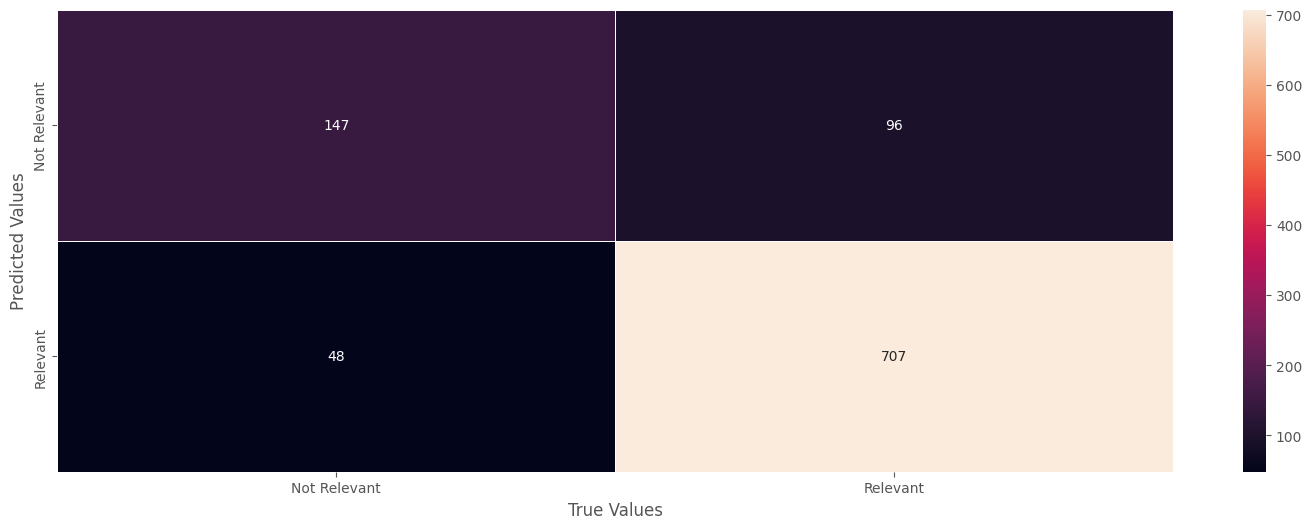

In [ ]:
p = save_history(history = history, path = "./training_info", name="bert_syn")
c = save_cm(path = "./training_info", cm = cm, name='bert_syn')
plot_cm(cm, normalize_cm = False)

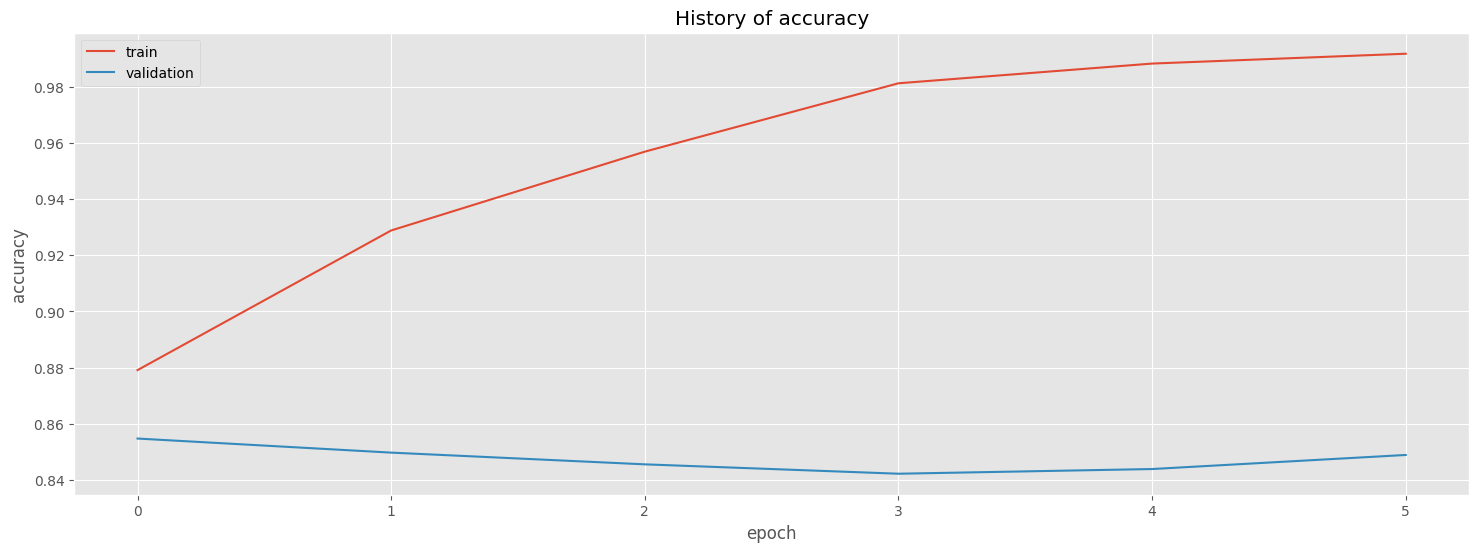

In [ ]:
learner.plot('accuracy')

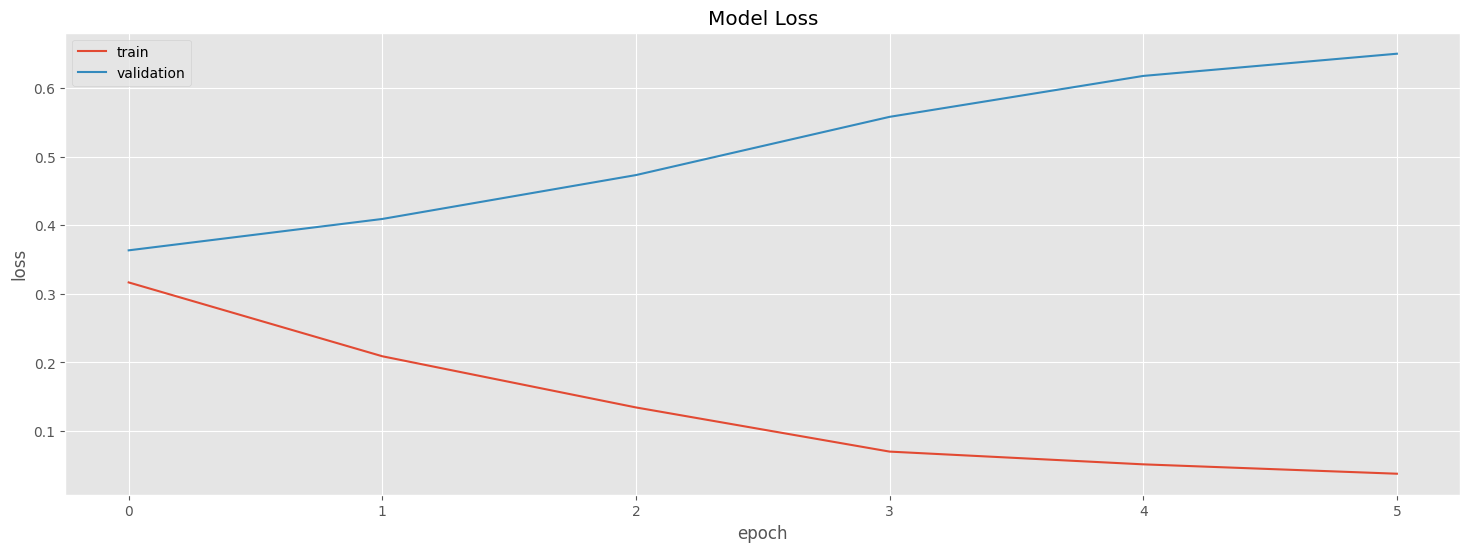

In [ ]:
learner.plot('loss')

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
predictor.predict('I like trains and disasters')

'Not Relevant'

## Bert twitter

1.   Load the model (this time we'll try DistilBERT, which is a smaller transformer model)

In [ ]:
MODEL_NAME = 'aellxx/raw_disaster_tweets'
transformer = text.Transformer(MODEL_NAME, maxlen=MAX_LEN, classes=['Not Relevant','Relevant'])

2. Process the training/test data

In [ ]:
processed_train = transformer.preprocess_train(X_train, y_train)
processed_val = transformer.preprocess_test(X_val, y_val)
processed_test = transformer.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 22
	95percentile : 36
	99percentile : 46


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 36
	99percentile : 51


preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 37
	99percentile : 51


3. Create a model and learner

In [ ]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)

In [ ]:
display(model.summary())

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


None

Next, we call the lr_find and lr_plot methods to help identify a good learning rate.

In [ ]:
learner.lr_find(max_epochs=15)

simulating training for different learning rates... this may take a few moments...
Epoch 1/15
606/606 [==============================] - 123s 166ms/step - loss: 0.4387 - accuracy: 0.8111
Epoch 2/15
606/606 [==============================] - 103s 169ms/step - loss: 0.3794 - accuracy: 0.8406
Epoch 3/15
606/606 [==============================] - 103s 169ms/step - loss: 0.3320 - accuracy: 0.8647
Epoch 4/15
606/606 [==============================] - 103s 169ms/step - loss: 0.2816 - accuracy: 0.8868
Epoch 5/15
606/606 [==============================] - 102s 169ms/step - loss: 0.2423 - accuracy: 0.9140
Epoch 6/15
606/606 [==============================] - 102s 169ms/step - loss: 0.2815 - accuracy: 0.8921
Epoch 7/15
606/606 [==============================] - 25s 41ms/step - loss: 0.5613 - accuracy: 0.7525


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Invoke the larner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.

Three possible suggestions for LR from plot:
	Longest valley (red): 6.15E-06
	Min numerical gradient (purple): 1.27E-05
	Min loss divided by 10 (omitted from plot): 6.05E-06


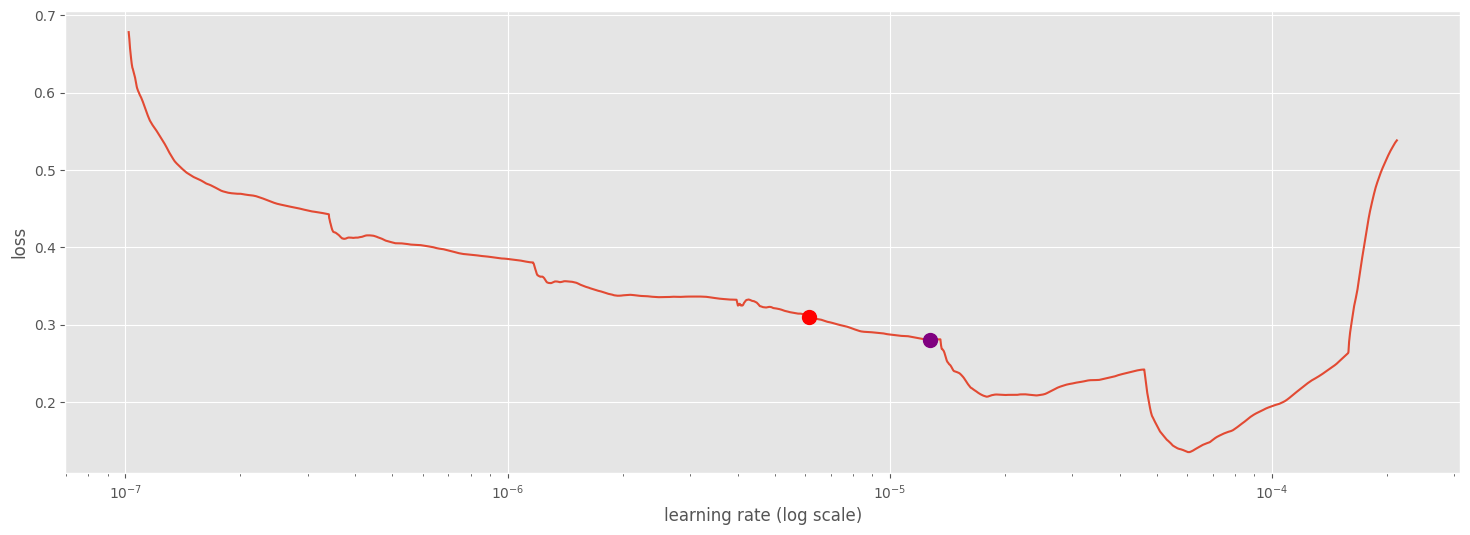

In [ ]:
learner.lr_plot(suggest=True)

In [ ]:
history = learner.autofit(6.05E-06, checkpoint_folder='./weights/twitter-bert-syn/', monitor = 'val_accuracy')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 6.05e-06...
Epoch 1/1024
606/606 [==============================] - 142s 199ms/step - loss: 0.3631 - accuracy: 0.8562 - val_loss: 0.3448 - val_accuracy: 0.8606
Epoch 2/1024
606/606 [==============================] - 114s 188ms/step - loss: 0.2536 - accuracy: 0.9070 - val_loss: 0.3635 - val_accuracy: 0.8539
Epoch 3/1024
606/606 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9358
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 3.025e-06 (if not early_stopping).
606/606 [==============================] - 117s 194ms/step - loss: 0.1848 - accuracy: 0.9358 - val_loss: 0.4118 - val_accuracy: 0.8523
Epoch 4/1024
606/606 [==============================] - 119s 197ms/step - loss: 0.1296 - accuracy: 0.9596 - val_loss: 0.4537 - val_accuracy: 0.8564
Epoch 5/1024
606/606 [===================

In [ ]:
cm = learner.validate(val_data = processed_test, print_report = False, class_names=transformer.get_classes(), save_path= "./training_info/bert_twitter_syn_report.csv")

998/998 [==============================] - 49s 46ms/step
classification report saved to: ./training_info/bert_twitter_syn_report.csv


In [ ]:
model_report = pd.read_csv("./training_info/bert_twitter_syn_report.csv")
model_report

Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.779006  0.580247  0.665094  243.000000
1      Relevant   0.875153  0.947020  0.909669  755.000000
2      accuracy   0.857715  0.857715  0.857715    0.857715
3     macro avg   0.827079  0.763633  0.787382  998.000000
4  weighted avg   0.851742  0.857715  0.850118  998.000000

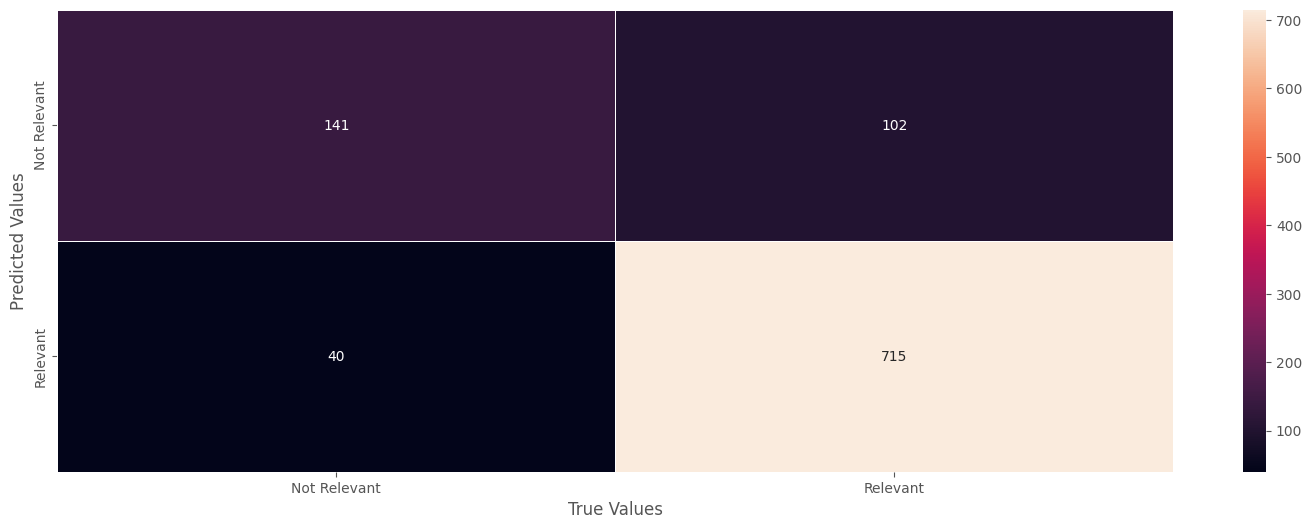

In [ ]:
p = save_history(history = history, path = "./training_info", name="bert_twitter_syn")
c = save_cm(path = "./training_info", cm = cm, name='bert_twitter_syn')
plot_cm(cm, normalize_cm = False)

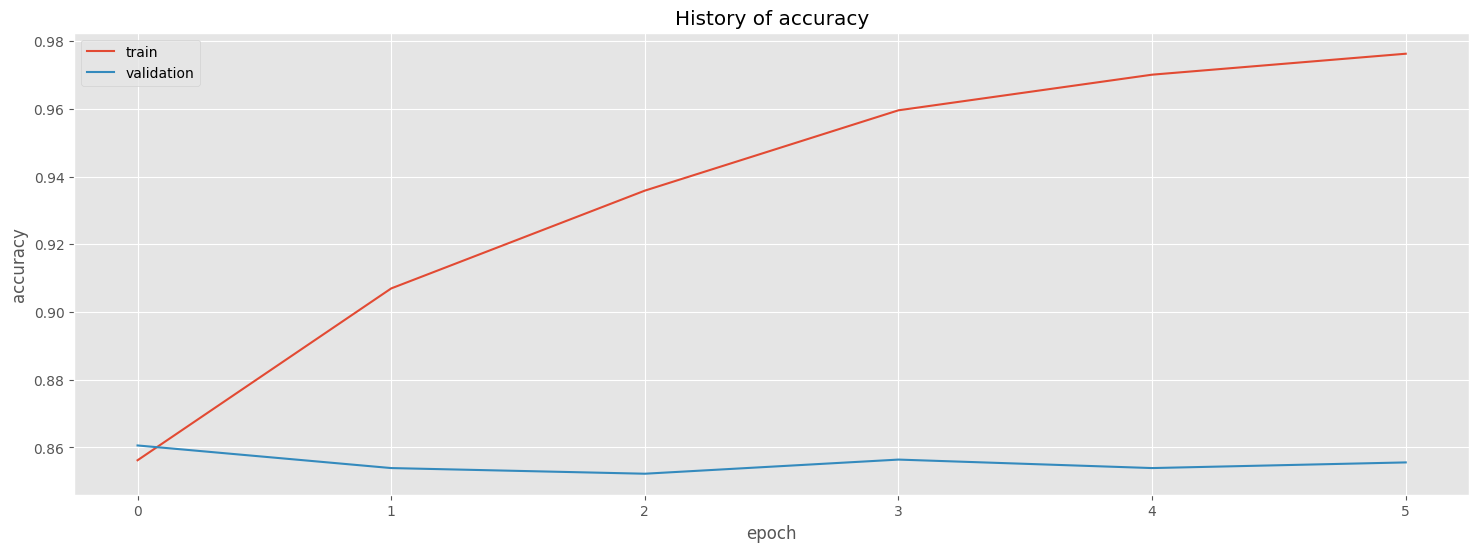

In [ ]:
learner.plot('accuracy')

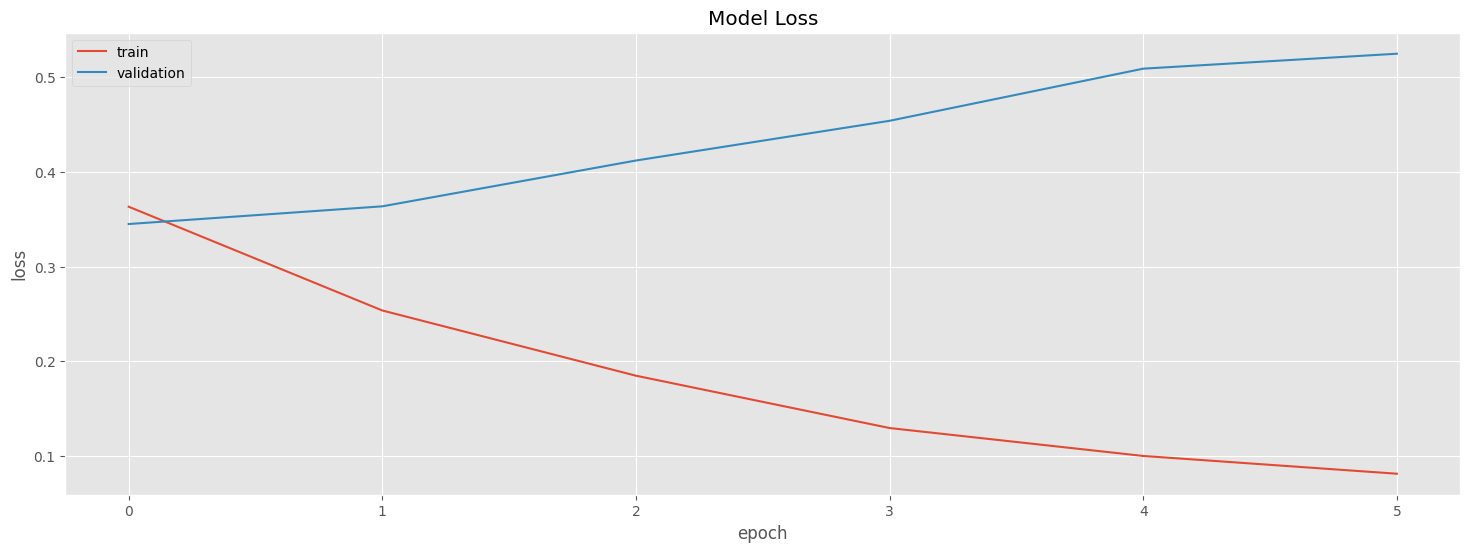

In [ ]:
learner.plot('loss')

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
predictor.predict('I like harvey disaster')

'Not Relevant'

# RESULTS COMPARISON

In [ ]:
import pandas as pd
import json

In [ ]:
glove = json.load(open("./training_info/glove_report.json"))
bert_base = pd.read_csv("./training_info/bert_report.csv")
bert_twitter_base = pd.read_csv("./training_info/bert_twitter_report.csv")

glove_plus = json.load(open("./training_info/glove_plus_report.json"))
bert_plus = pd.read_csv("./training_info/bert_plus_report.csv")
bert_twitter_plus = pd.read_csv("./training_info/twitter_bert_plus_report.csv")

bert_syn = pd.read_csv("./training_info/bert_syn_report.csv")
bert_twitter_syn = pd.read_csv("./training_info/bert_twitter_syn_report.csv")

In [ ]:
print("\n\n")

print("Bert base")
display(bert_base)
print("\n\n")


print("Bert twitter")
display(bert_twitter_base)
print("\n\n")

print("Glove plus")
display(glove_plus)
print("\n\n")

print("Bert plus")
display(bert_plus)
print("\n\n")

print("Bert twitter plus")
display(bert_twitter_plus)
print("\n\n")

print("Bert syn")
display(bert_syn)
print("\n\n")

print("Bert twitter syn")
display(bert_twitter_syn)
print("\n\n")

Glove base


{'0': {'precision': 0.5015337423312883,
  'recall': 0.7482837528604119,
  'f1-score': 0.6005509641873278,
  'support': 437},
 '1': {'precision': 0.9461839530332681,
  'recall': 0.8561310314298363,
  'f1-score': 0.8989077387868929,
  'support': 2259},
 'accuracy': 0.8386498516320475,
 'macro avg': {'precision': 0.7238588476822783,
  'recall': 0.802207392145124,
  'f1-score': 0.7497293514871104,
  'support': 2696},
 'weighted avg': {'precision': 0.8741097163579102,
  'recall': 0.8386498516320475,
  'f1-score': 0.850546496019827,
  'support': 2696}}




Bert base


Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.725275  0.543210  0.621176  243.000000
1      Relevant   0.863971  0.933775  0.897518  755.000000
2      accuracy   0.838677  0.838677  0.838677    0.838677
3     macro avg   0.794623  0.738492  0.759347  998.000000
4  weighted avg   0.830200  0.838677  0.830232  998.000000




Bert twitter


Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.820000  0.506173  0.625954  243.000000
1      Relevant   0.858491  0.964238  0.908297  755.000000
2      accuracy   0.852705  0.852705  0.852705    0.852705
3     macro avg   0.839245  0.735206  0.767126  998.000000
4  weighted avg   0.849119  0.852705  0.839550  998.000000




Glove plus


{'0': {'precision': 0.6049382716049383,
  'recall': 0.75,
  'f1-score': 0.6697038724373576,
  'support': 196},
 '1': {'precision': 0.9350993377483444,
  'recall': 0.8802992518703242,
  'f1-score': 0.9068721901091844,
  'support': 802},
 'accuracy': 0.8547094188376754,
 'macro avg': {'precision': 0.7700188046766414,
  'recall': 0.815149625935162,
  'f1-score': 0.788288031273271,
  'support': 998},
 'weighted avg': {'precision': 0.8702580862813026,
  'recall': 0.8547094188376754,
  'f1-score': 0.8602940435523928,
  'support': 998}}




Bert plus


Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.784946  0.600823  0.680653  243.000000
1      Relevant   0.880542  0.947020  0.912572  755.000000
2      accuracy   0.862725  0.862725  0.862725    0.862725
3     macro avg   0.832744  0.773921  0.796612  998.000000
4  weighted avg   0.857266  0.862725  0.856103  998.000000




Bert twitter plus


Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.812155  0.604938  0.693396  243.000000
1      Relevant   0.882497  0.954967  0.917303  755.000000
2      accuracy   0.869739  0.869739  0.869739    0.869739
3     macro avg   0.847326  0.779953  0.805350  998.000000
4  weighted avg   0.865370  0.869739  0.862784  998.000000




Bert syn


Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.753846  0.604938  0.671233  243.000000
1      Relevant   0.880448  0.936424  0.907574  755.000000
2      accuracy   0.855711  0.855711  0.855711    0.855711
3     macro avg   0.817147  0.770681  0.789403  998.000000
4  weighted avg   0.849622  0.855711  0.850028  998.000000




Bert twitter syn


Unnamed: 0  precision    recall  f1-score     support
0  Not Relevant   0.779006  0.580247  0.665094  243.000000
1      Relevant   0.875153  0.947020  0.909669  755.000000
2      accuracy   0.857715  0.857715  0.857715    0.857715
3     macro avg   0.827079  0.763633  0.787382  998.000000
4  weighted avg   0.851742  0.857715  0.850118  998.000000